# Calculation of different ML methods for prediction of Pulmonary hypertension (PH)

* Random forests
* XGBoost

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
import xgboost as xgb
import random
seed=123
random.seed = seed
POSITIVE_LABEL = 'PH'
NEGATIVE_LABEL = 'HC DC'

In [27]:
filename = 'Bordag_et_al_2023_FFAlipid_biomarker_PH_Supplementary_data_1.xlsx'
df_train_driftcorr = pd.read_excel(filename, sheet_name="training_Ravg_LOG_driftcorr", header=[0])
df_val_driftcorr = pd.read_excel(filename, sheet_name="validation_Ravg_LOG_driftcorr", header=[0])
df_train = pd.read_excel(filename, sheet_name="training_Ravg_LOG", header=[0])
df_val = pd.read_excel(filename, sheet_name="validation_Ravg_LOG", header=[0])

In [28]:
# get only columns with metabolites
df_param_labels = pd.read_excel(filename, sheet_name="parameter_info")

# get jr_ids for all hydrophilic metabolites
jr_ids = []
for i in range(len(df_param_labels)):
    if df_param_labels['Metabolite_Class'][i] in ['Fatty acids and metabolites', 'Lipids, steroids, bile acids and metabolites']:
        jr_ids.append(df_param_labels['JR_ID'][i])

## Functions

In [54]:
# impute features with KNNImputer
def get_imputed_dataset(df_train, df_val, col_imp):
    imputed_columns = {}
    df_train_new = df_train[col_imp].copy()
    df_val_new = df_val[col_imp].copy()
    df = pd.concat([df_train_new, df_val_new], ignore_index=True)

    # all columns with nan
    col_nan = df.isna().any()

    for c in col_nan.index:
        # imputation
        if col_nan[c]:
            # check if more than 30% missing
            if df_train[c].isna().sum() < len(df_train[c])*0.3:  
                imputed_columns[c]=df_train[c].isna().sum()         
                imputer = KNNImputer(n_neighbors=2, weights="uniform")
                new_c_train = imputer.fit(np.array(df_train[c]).reshape(-1, 1) )
                new_c_val = imputer.transform(np.array(df_val[c]).reshape(-1, 1) )
                new_c_train = imputer.transform(np.array(df_train[c]).reshape(-1, 1) )
                df_val_new.loc[:,c] = new_c_val
                df_train_new.loc[:,c] = new_c_train

    return df_train_new, df_val_new, imputed_columns

# normalize data
def normalize(data, columns=[]):
    data_normalized = {}
    dn_list = []

    for c in data.columns[2:len(data.columns)]:
        if (data[c] == data[c]).all():
            if c == 'sex':
                c_new = data[c] == 'female'
            else:
                c_new = (data[c].values - min(data[c].values))/(max(data[c].values)-min(data[c].values))
            if columns:
                if c in columns:
                    dn_list.append(list(c_new))
                    data_normalized[c] =c_new
            else:
                dn_list.append(list(c_new))
                data_normalized[c] =c_new
        else:
            print('Nans in column:',c)
    return data_normalized, dn_list

def flat(list):
    return [item for subl in list for item in subl]

def get_Xy(data):
    _, X = normalize(data)
    X = np.asarray(X).T
    y = data['class']==POSITIVE_LABEL
    return X,y

def calc_model(modelname, hyper_parameter):
    # random forest
    if modelname=='rf':
        no_trees = hyper_parameter[0]
        depth = hyper_parameter[1]
        model = RandomForestClassifier(max_depth=depth, random_state=seed, n_estimators=no_trees)
    # extreme gradient boosting
    elif modelname=='xg':
        learning_rate = hyper_parameter[0]
        max_depth = hyper_parameter[1]
        n_estimators = hyper_parameter[2]
        model = xgb.XGBClassifier(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = learning_rate,
                max_depth = max_depth, alpha = 10, n_estimators = n_estimators, random_state=seed)
    return model

def get_hyperparameter(hyp_param, modelname):
    if hyp_param:
        return hyp_param
    else:
        if modelname == 'rf':
            # no of trees and depth
            return [[1001,5]]
        elif modelname=='xg':
            # eta and max depth and n_estimators
            return[[0.1,5,10]]

def get_age_level(age_col, level):
    level_split = (max(age_col)-min(age_col))/level
    age_level = []
    
    for a in age_col:
        threshold = min(age_col)
        level_count = 0
        while a >= threshold:
            threshold += level_split
            level_count+=1
        age_level.append(level_count)

    return age_level

def get_random_split(data, selected_col,split_no=5):
    split_ids = []
    split_indices = []
    at_least = 1
    ## age
    data['age_level'] = get_age_level(data['age'], 5)
    df_drop = data.copy()
    for split in range(split_no,0,-1):
        test_proportion = 1/split
        # grouping by gender, label and age
        grps = df_drop.groupby(['sex','class', 'age_level'], group_keys=False)
        # selection by test_proportion and grouping
        test = grps.apply(lambda x: x.sample(max(round(len(x)*test_proportion), at_least), random_state = seed))
        split_ids.extend(test.index)
        split_indices.append(test[selected_col])
        df_drop = data.copy()
        df_drop.drop(split_ids, inplace=True)

    return split_indices

def test_model(train_set, val_set, col, modelname, drift, hyper_param=[], title='Metabolites'):
    data = train_set
    
    print('Results for '+modelname+' and '+drift+' for all '+title)

    selected_col = 'Sample_Name'

    threshold_cm=0.5
    tprs_val = []
    fprs_val = []
    aucs_val = []
    tprs_test = []
    fprs_test = []
    aucs_test = []
    cm_test = []
    fi = []
    interp_mean_fpr = np.linspace(0, 1, 100)
    cm_val = []
    y_hat_vals = []
    y_vals = []
    # parameters for AUROC
    linesize = 0.25
    w_ROC = 5.0
    h_ROC = 5.0

    col_train, col_val = get_color(modelname)
    
    # set hyperparameter
    hyp = get_hyperparameter(hyper_param, modelname)
    split = get_random_split(data.copy(), selected_col)

    data = data[col]
    val_set = val_set[col]
    
    # plotting
    plt.rcParams['axes.linewidth'] = linesize
    fig, ax = plt.subplots(1,figsize=(w_ROC,h_ROC))
    # make grid in the background
    ax.set_axisbelow(True)
    ax.grid(which='major', linestyle='dashed', color='#E6E6E6', dashes=(8,8))

    # cross validation over all splits
    for s in split:
        # get train and test split
        test_set = data[data[selected_col].isin(s)].copy()
        train_set = data[data[selected_col].isin(list(set(flat(split))-set(s)))].copy()

        X_train, y_train = get_Xy(train_set)
        X_test, y_test = get_Xy(test_set)
        X_val, y_val = get_Xy(val_set) 
        
        # train the model
        model = calc_model(modelname, hyp)
        model.fit(X_train, y_train)

        # test the model
        y_hat_test = model.predict_proba(X_test) 
        fi.append(model.feature_importances_)

        fpr_test, tpr_test, threshold_test = roc_curve(y_test,y_hat_test[:,1]) 
        auc_test = roc_auc_score(y_test,y_hat_test[:,1]) 

        # Interpolation
        interp_tpr = np.interp(interp_mean_fpr, fpr_test, tpr_test)
        interp_tpr[0] = 0.0
        tpr_test = interp_tpr
        fpr_test = interp_mean_fpr
        conf_m_test = confusion_matrix(y_test, y_hat_test[:,1]>threshold_cm)
 
        tprs_test.append(tpr_test)
        fprs_test.append(fpr_test)
        aucs_test.append(auc_test)
        cm_test.append(conf_m_test)

        # validation
        y_hat_val = model.predict_proba(X_val) 
        y_hat_vals.append(y_hat_val[:,1])
        y_vals.append(y_val)
        fpr_val, tpr_val, threshold = roc_curve(y_val,y_hat_val[:,1]) 
        auc_val = roc_auc_score(y_val,y_hat_val[:,1]) 
        conf_m_val = confusion_matrix(y_val, y_hat_val[:,1]>threshold_cm)

        # Interpolation of tpr and fpr for AUC
        interp_tpr_val = np.interp(interp_mean_fpr, fpr_val, tpr_val)
        interp_tpr_val[0] = 0.0
        tpr_val = interp_tpr_val
        fpr_val = interp_mean_fpr

        tprs_val.append(tpr_val)
        fprs_val.append(fpr_val)
        aucs_val.append(auc_val)
        cm_val.append(conf_m_val)

    mean_tpr = np.mean(tprs_test, axis=0)
    ax.plot([0, 1], [0, 1], lw=2, color="#D2D2D2", alpha=0.6)
    mean_tpr[-1] = 1.0
    mean_auc = auc(interp_mean_fpr, mean_tpr)
    
    #################################################
    # plot train
    ax.plot(
        interp_mean_fpr,
        mean_tpr,
        color=col_train,
        lw=2,
        alpha=0.8,
    )
    # calculate 95% CI for plot
    std_tpr_test = np.std(tprs_test, axis=0)
    tprs_upper_test = np.minimum(mean_tpr + 0.95*std_tpr_test, 1)
    tprs_lower_test = np.maximum(mean_tpr - 0.95*std_tpr_test, 0)

    ax.fill_between(
        interp_mean_fpr,
        tprs_lower_test,
        tprs_upper_test,
        color=col_train,
        alpha=0.2,
    )

    #######################################################
    # plot  validation
 
    mean_tpr_val = np.mean(tprs_val, axis=0)
    mean_tpr_val[-1] = 1.0
    mean_auc_val = auc(interp_mean_fpr, mean_tpr_val)

    ax.plot(
        interp_mean_fpr,
        mean_tpr_val,
        color=col_val,
        linestyle='dashed',
        lw=2,
        alpha=0.8,
    )
    
    # Calculate 95% CI
    std_tpr_val = np.std(tprs_val, axis=0)
    tprs_upper_val = np.minimum(mean_tpr_val + 0.95*std_tpr_val, 1)
    tprs_lower_val = np.maximum(mean_tpr_val - 0.95*std_tpr_val, 0)
    
    ax.fill_between(
        interp_mean_fpr,
        tprs_lower_val,
        tprs_upper_val,
        color=col_val,
        alpha=0.2,
    )
    ##################################################

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
    )

    ax.text(0.95,0.08, r"train AUC %0.2f" % (mean_auc), horizontalalignment='right')
    ax.text(0.95,0, r"val AUC %0.2f" % (mean_auc_val), horizontalalignment='right')
    
    fig.set_dpi(600)

    # statistics
    model_type = modelname+drift+title
    df_save = pd.DataFrame(index=[model_type])
    sp, se, acc, bacc, df_save = get_statistical_values(cm_test, df_save, model_type, prefix='test')
    print('Train Sensitivity: ', se, ' Specificity: ', sp, ' Accuracy: ',acc, ' Balanced Accuracy: ', bacc)
    sp, se, acc, bacc, df_save = get_statistical_values(cm_val, df_save, model_type, prefix='val')
    print('Validation Sensitivity: ', se, ' Specificity: ', sp, ' Accuracy: ',acc, ' Balanced Accuracy: ', bacc)
    sp, se, acc, bacc, df_save = get_statistical_values(cm_test+cm_val, df_save, model_type, prefix='joint')
    print('Joint Sensitivity: ', se, ' Specificity: ', sp, ' Accuracy: ',acc, ' Balanced Accuracy: ', bacc)
    df = pd.DataFrame(data={'test_AUC':[mean_auc], 'val_AUC':[mean_auc_val], 'joint_AUC':[(mean_auc_val+mean_auc)/2]},index=[model_type])
    df_save = df_save.join(df)       
 
    return df_save

def get_color(modelname):
    if modelname=='rf':
        return 'green', "#0EF047"
    elif modelname=='xg':
        return '#0000ff', '#74AFF7'

# Confusionmatrix
# TP FN
# FP TN
# sensitivity tpr = TP/P
# specificity tnr = TN/N
# accuracy = (tp + tn)/(p+n)
# balanced accuracy = (tpr+tnr)/2
def get_statistical_values(cm_list, df_save, model_type, prefix=''):
    if prefix !='': prefix=prefix+'_'
    cm = np.mean(cm_list, axis=0)
    sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
    specificity = cm[1,1]/(cm[1,1]+cm[0,1])
    accuracy = (cm[1,1]+cm[0,0])/(cm[1,0]+cm[0,1]+cm[1,1]+cm[0,0])
    bacc = (sensitivity+specificity)/2

    df = pd.DataFrame(data={prefix+'Sensitivity':[sensitivity], prefix+'Specificity':[specificity], prefix+'Accuracy':[accuracy], prefix+'BACC':[bacc]},index=[model_type])
    df_save = df_save.join(df)

    return specificity, sensitivity, accuracy, bacc, df_save

def get_hydrophilic_columns(col, jr_ids):
    hydro_col=[]
    for id in jr_ids:
        colnew = [s for s in col if str(id) in s]
        #colnew = get_string_from_substring(col, str(id))
        if colnew:
            hydro_col.extend(colnew)
    return hydro_col

# All metabolite columns for drift corrected (OEME) and not drift corrected (OE) data
# add_col ... additional columns to metabolites
def get_columns(df_drifcorr, df_drift, add_col):
    col1 = df_drifcorr.columns[df_drifcorr.columns.str.contains('Metab_MVA_UVA.')]
    col2 = col1[col1.str.contains('\.LOG_QCRFSC_Peakarea_OEME')]
    col_OEME = add_col+list(col2)
    col3 = df_drift.columns[df_drift.columns.str.contains('Metab_MVA_UVA.')]
    col4 = col3[col3.str.contains('\.LOG_Peakarea_OE')]
    col_OE = add_col+list(col4)
    return col_OEME, col_OE


### Selected columns for 
- all suitable metabolites
- only hydrophilic metabolites
- only lipophilic metabolites

In [30]:
# for saving data in file
df_results = pd.DataFrame()

# Constants
all_metab = 'suitable metabolites'
all_hyd = 'hydrophilic metabolites'
all_lip = 'lipophilic FFAs&lipids'
no_drift = '(not drift corrected)'
# additional columns to metabolites
add_col = ['Sample_Name', 'class', 'age', 'sex', 'BMI']

# columns
col_OEME, col_OE = get_columns(df_train_driftcorr, df_train, add_col)

col_metabolites_oeme = get_hydrophilic_columns(col_OEME,jr_ids)
col_hydrophilic_oeme =  add_col + col_metabolites_oeme.copy()
col_lipophilic_oeme = list(set(col_OEME) - set(col_metabolites_oeme) - set(add_col))
col_lipophilic_oeme.sort()
col_lipophilic_oeme = add_col + col_lipophilic_oeme

col_metabolites_oe = get_hydrophilic_columns(col_OE,jr_ids)
col_hydrophilic_oe = add_col + col_metabolites_oe.copy()
col_lipophilic_oe = list(set(col_OE) - set(col_metabolites_oe) - set(add_col))
col_lipophilic_oe.sort()
col_lipophilic_oe = add_col + col_lipophilic_oe

### Imputation

In [31]:
df_train_driftcorr_new, df_val_driftcorr_new, df_driftcorr_imp_col = get_imputed_dataset(df_train_driftcorr,df_val_driftcorr, col_OEME)
df_train_new, df_val_new, df_driftcorr_imp_col = get_imputed_dataset(df_train,df_val, col_OE)

----------------------------------------------------------

## Calculations and Results(ML Part)

### calculate random forest with not drift corrected data

In [56]:
modelname = 'rf'
drift = 'drift correction'
hyper_param = [3001, 300]

Results for rf and drift correction for all suitable metabolites
Train Sensitivity:  0.9411764705882353  Specificity:  0.8214285714285714  Accuracy:  0.8816568047337279  Balanced Accuracy:  0.8813025210084033
Validation Sensitivity:  0.22012578616352202  Specificity:  1.0  Accuracy:  0.6125  Balanced Accuracy:  0.610062893081761
Joint Sensitivity:  0.4713114754098361  Specificity:  0.9387755102040817  Accuracy:  0.7055214723926381  Balanced Accuracy:  0.7050434928069589


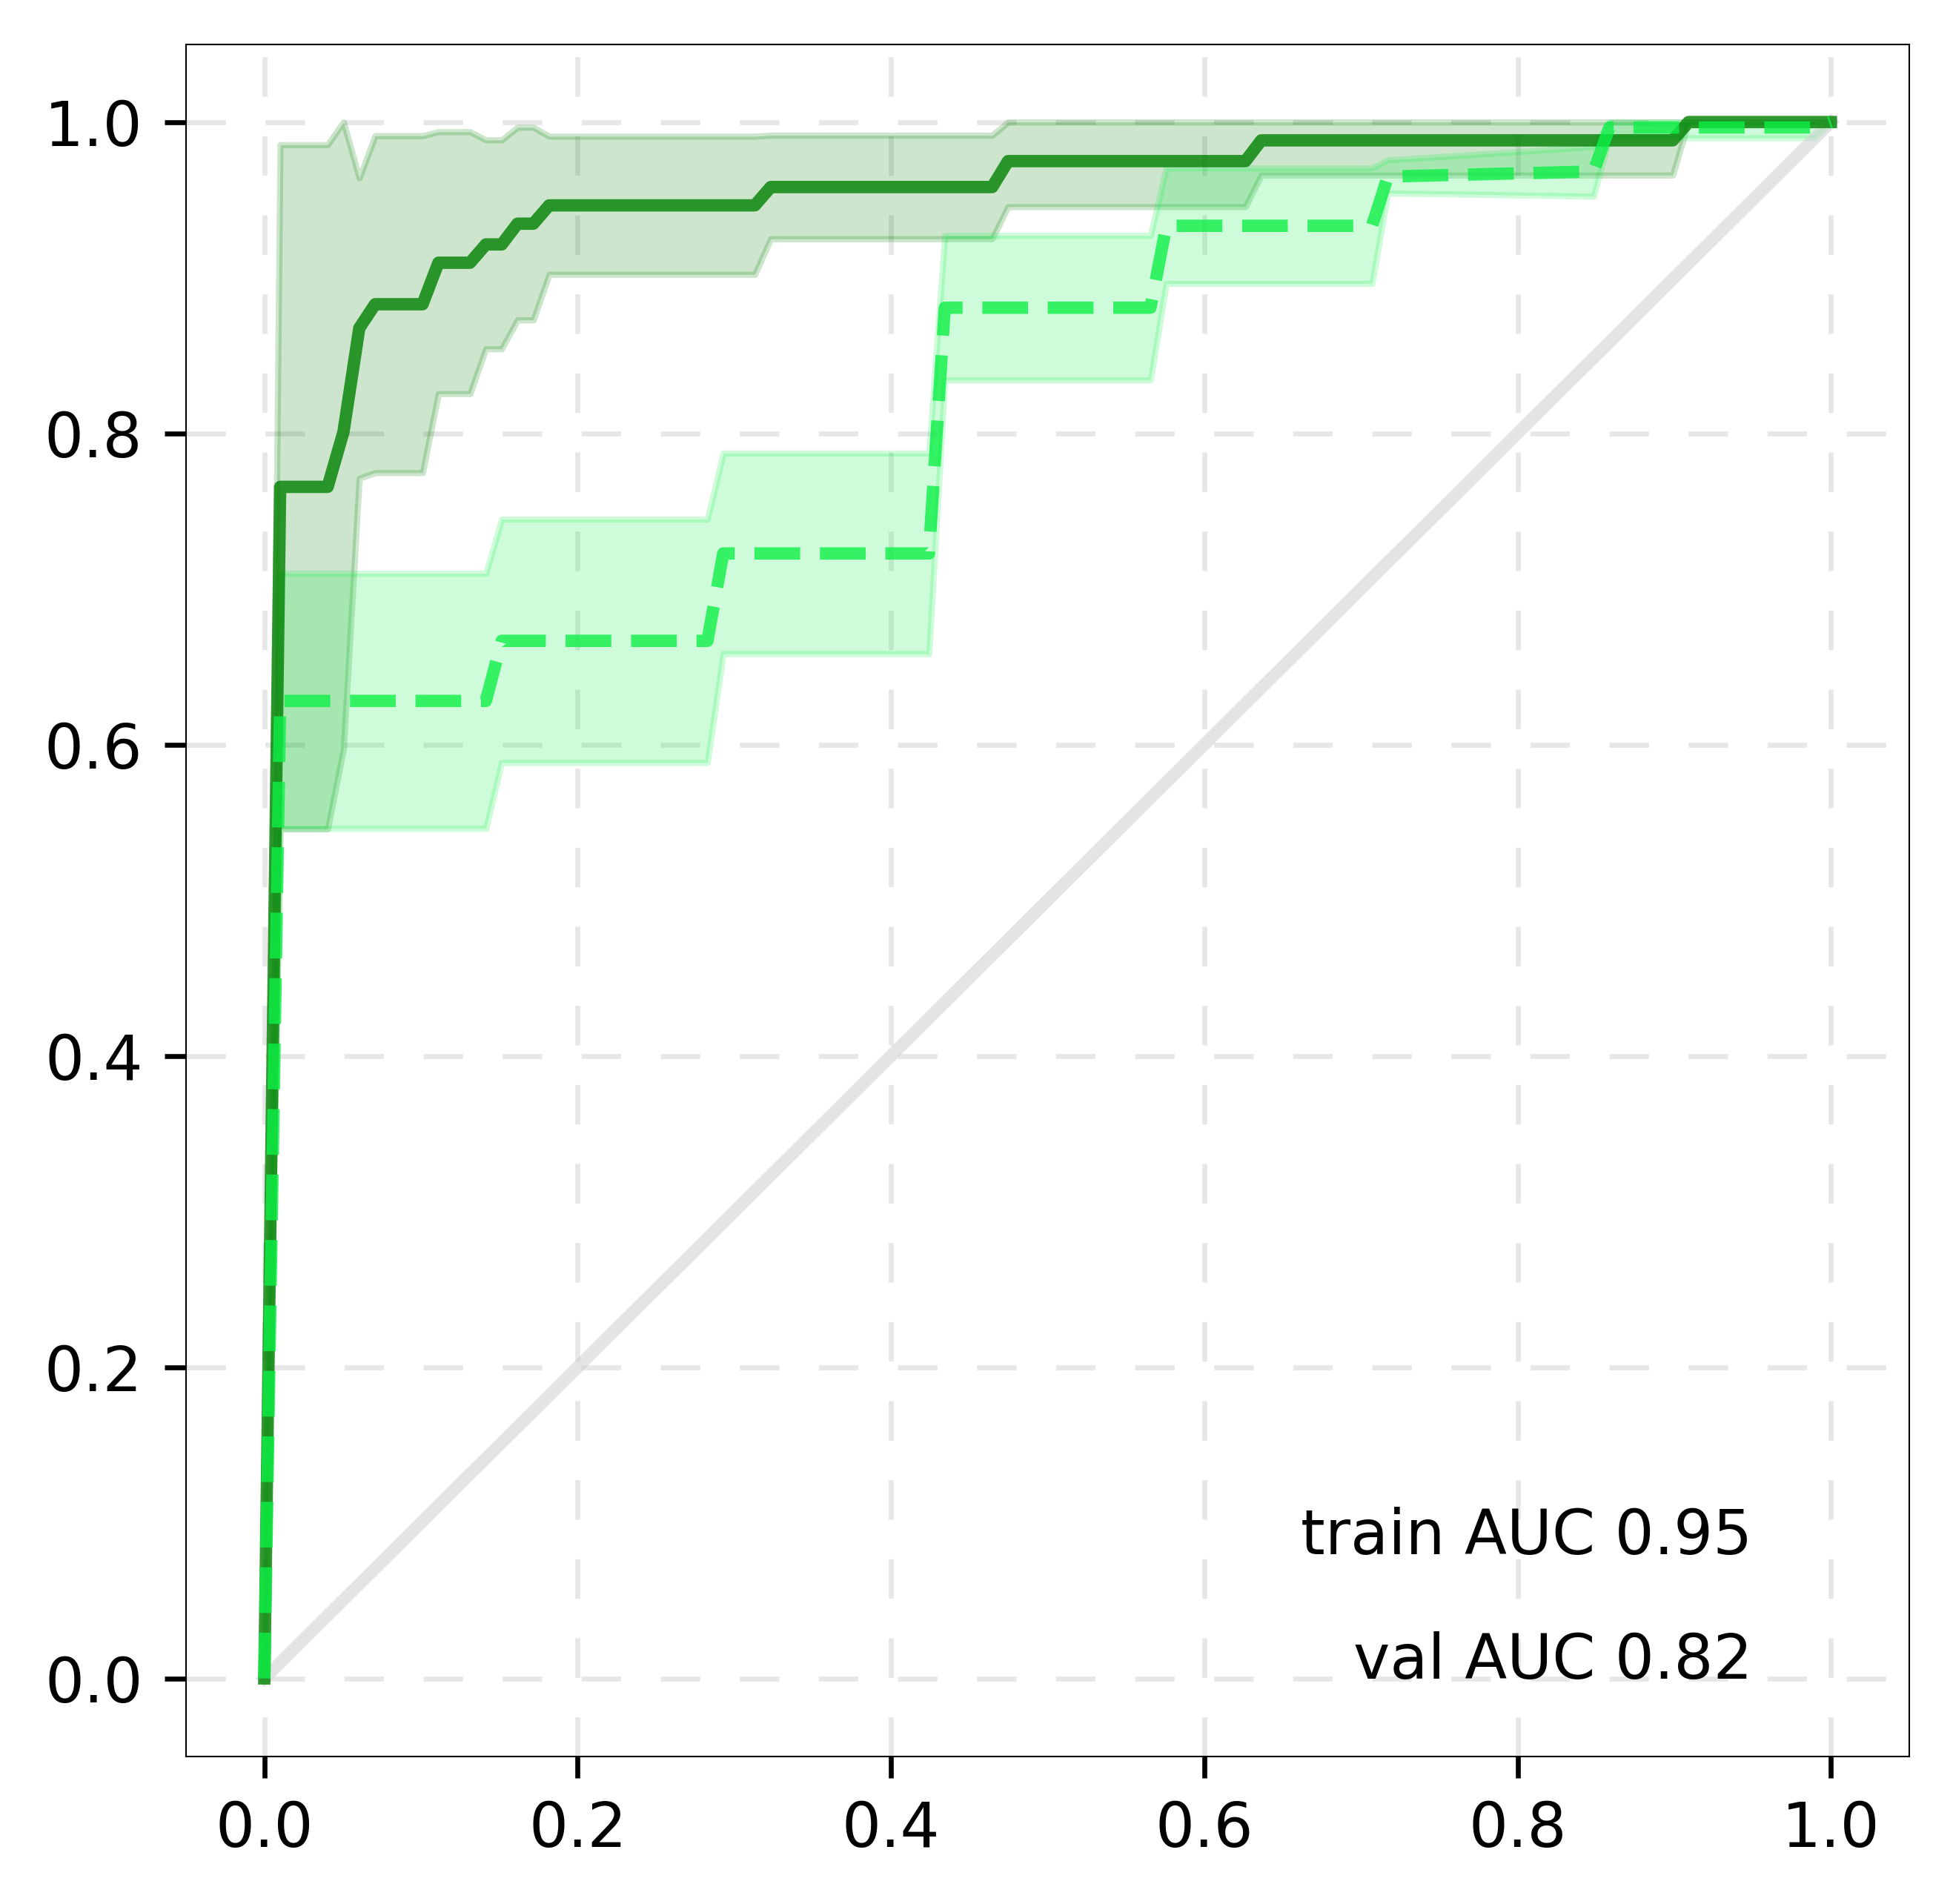

In [57]:
# all suitable metabolites
df_save = test_model(df_train_driftcorr_new, df_val_driftcorr_new, col_OEME, title=all_metab, modelname=modelname, drift=drift, hyper_param=hyper_param)
df_results = pd.concat([df_results,df_save])

Results for rf and drift correction for all hydrophilic metabolites
Train Sensitivity:  0.9135802469135803  Specificity:  0.7613636363636364  Accuracy:  0.8343195266272191  Balanced Accuracy:  0.8374719416386083
Validation Sensitivity:  0.1751824817518248  Specificity:  0.9398907103825136  Accuracy:  0.6124999999999999  Balanced Accuracy:  0.5575365960671692
Joint Sensitivity:  0.44954128440366975  Specificity:  0.8819188191881919  Accuracy:  0.6891615541922292  Balanced Accuracy:  0.6657300517959308


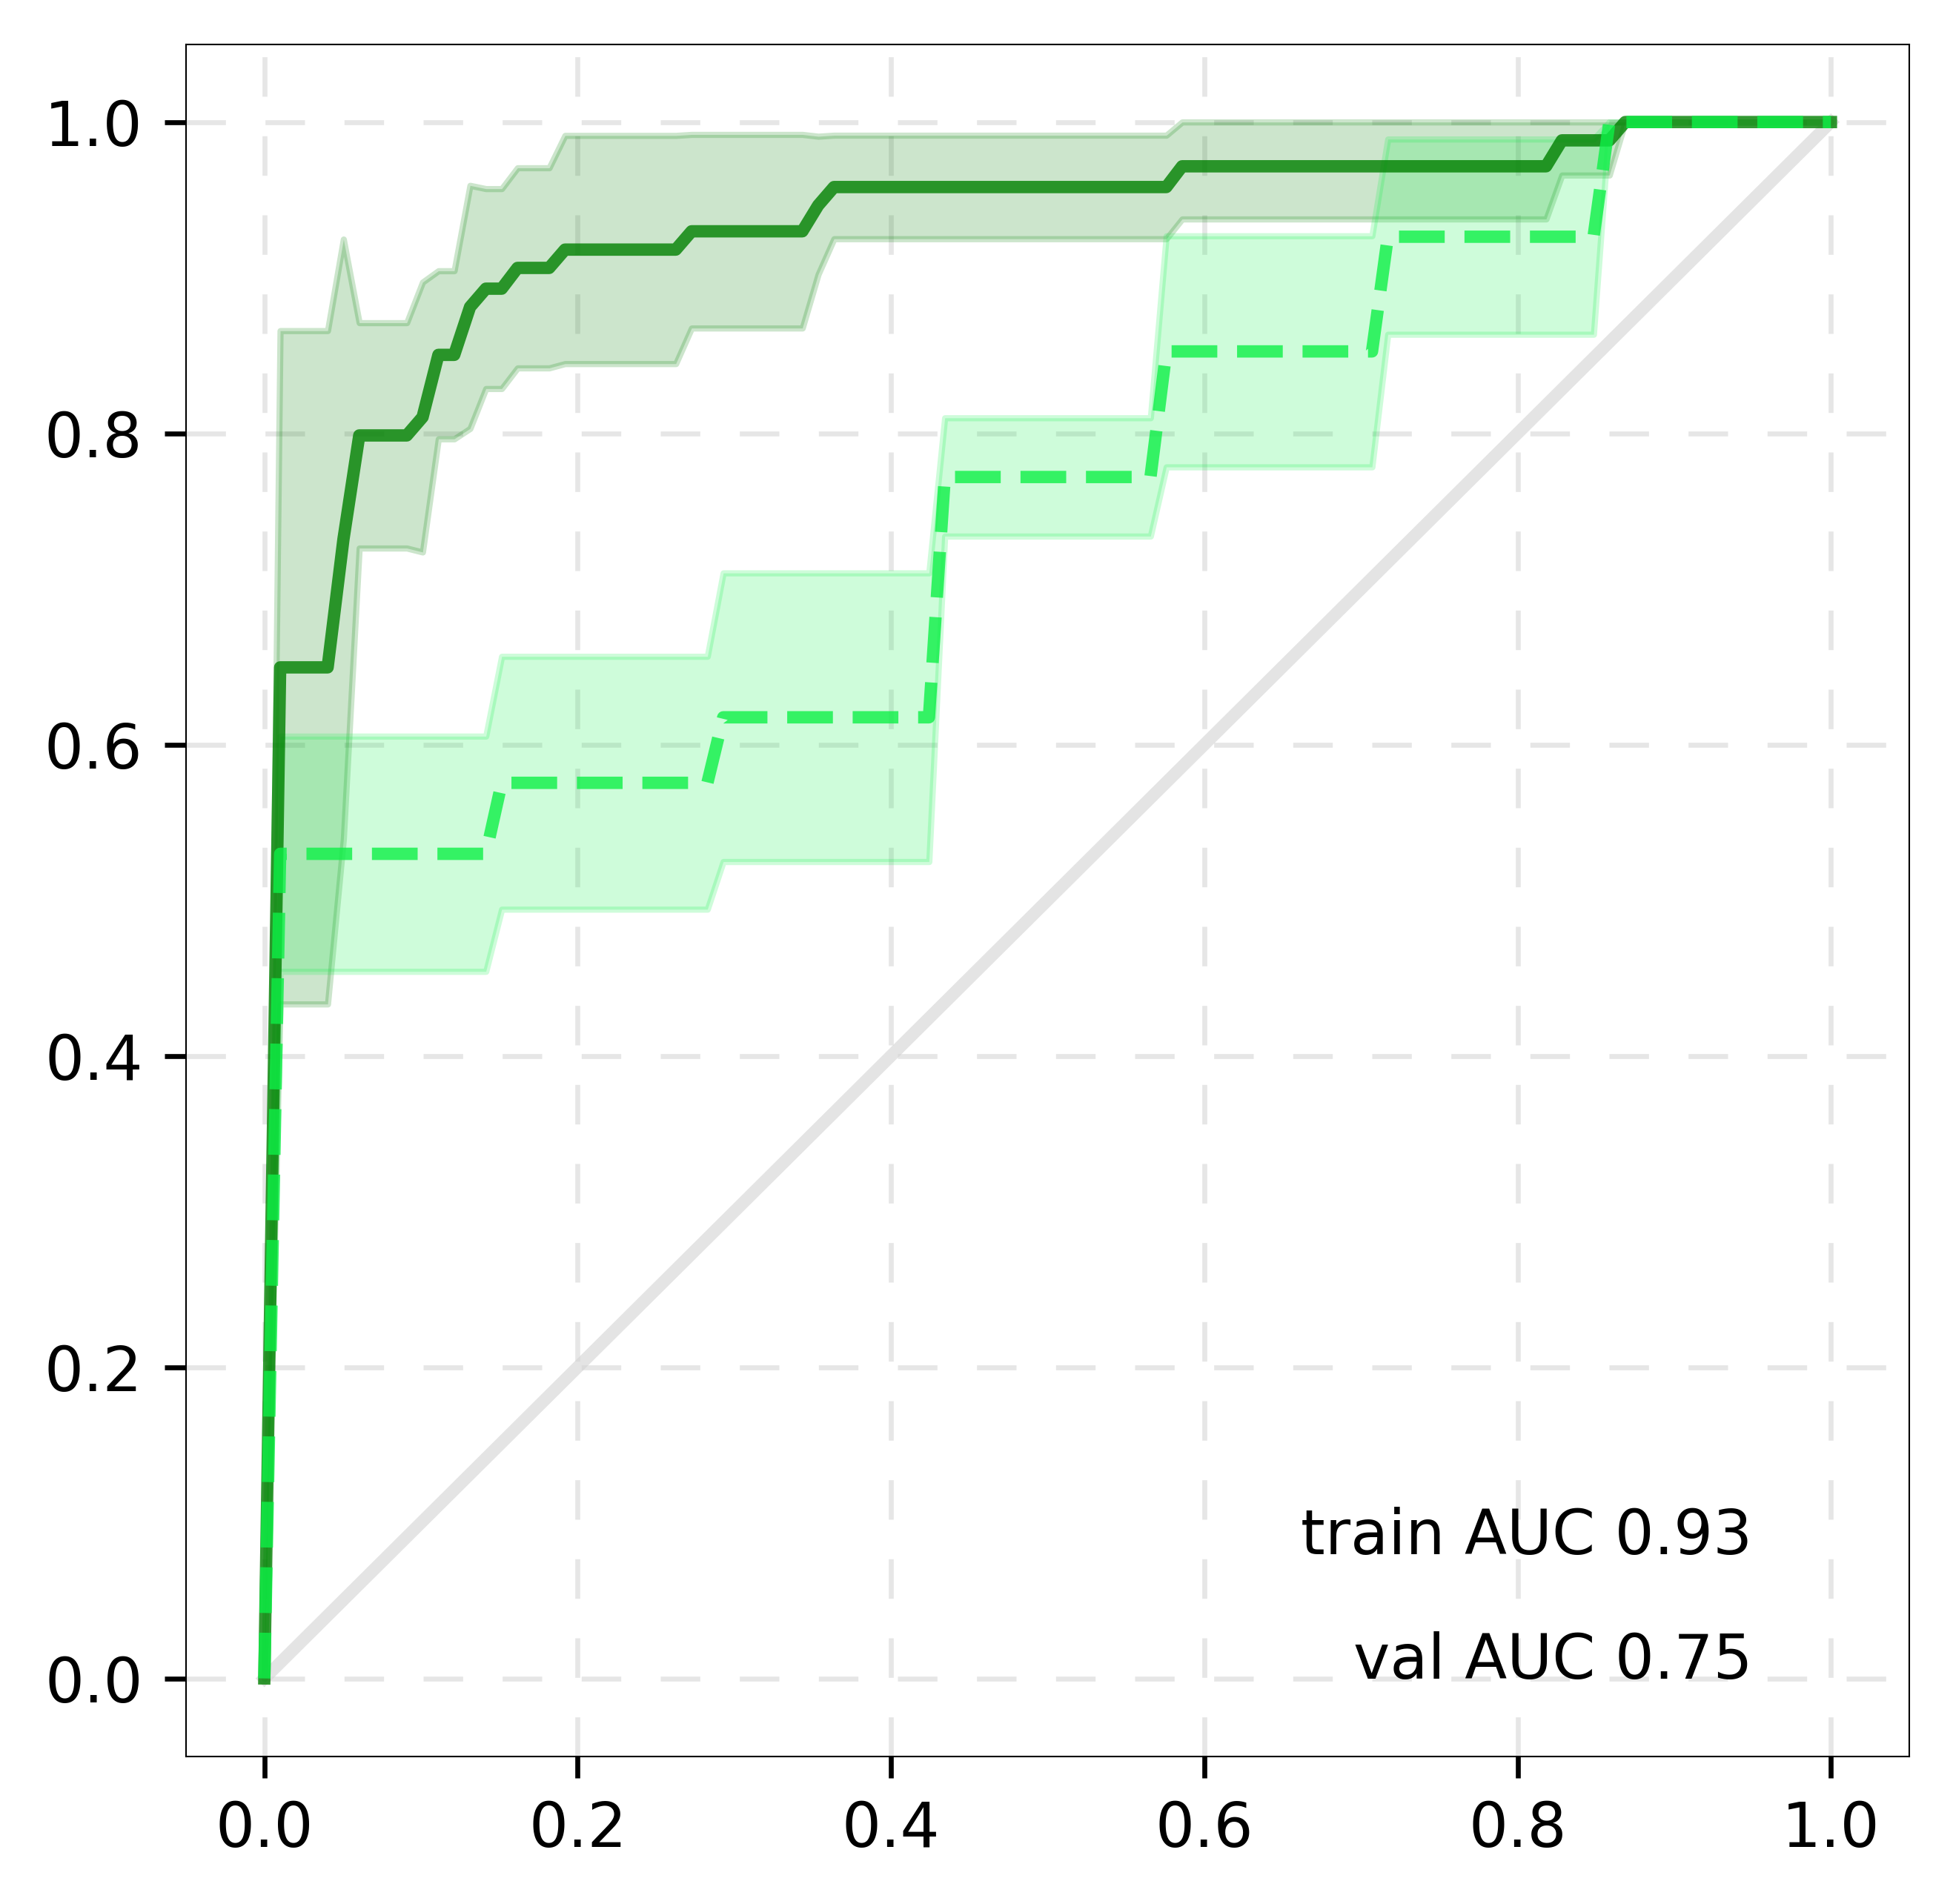

In [34]:
# all hydrophilic metabolites and drift correction in rf
df_save = test_model(df_train_driftcorr_new, df_val_driftcorr_new, col_hydrophilic_oeme, title=all_hyd, modelname=modelname, drift=drift, hyper_param=hyper_param)
df_results = pd.concat([df_results,df_save])

Results for rf and drift correction for all lipophilic FFAs&lipids
Train Sensitivity:  0.8842105263157896  Specificity:  0.8513513513513513  Accuracy:  0.8698224852071006  Balanced Accuracy:  0.8677809388335704
Validation Sensitivity:  0.2095808383233533  Specificity:  1.0  Accuracy:  0.5875  Balanced Accuracy:  0.6047904191616766
Joint Sensitivity:  0.4541984732824427  Specificity:  0.9515418502202643  Accuracy:  0.6850715746421268  Balanced Accuracy:  0.7028701617513535


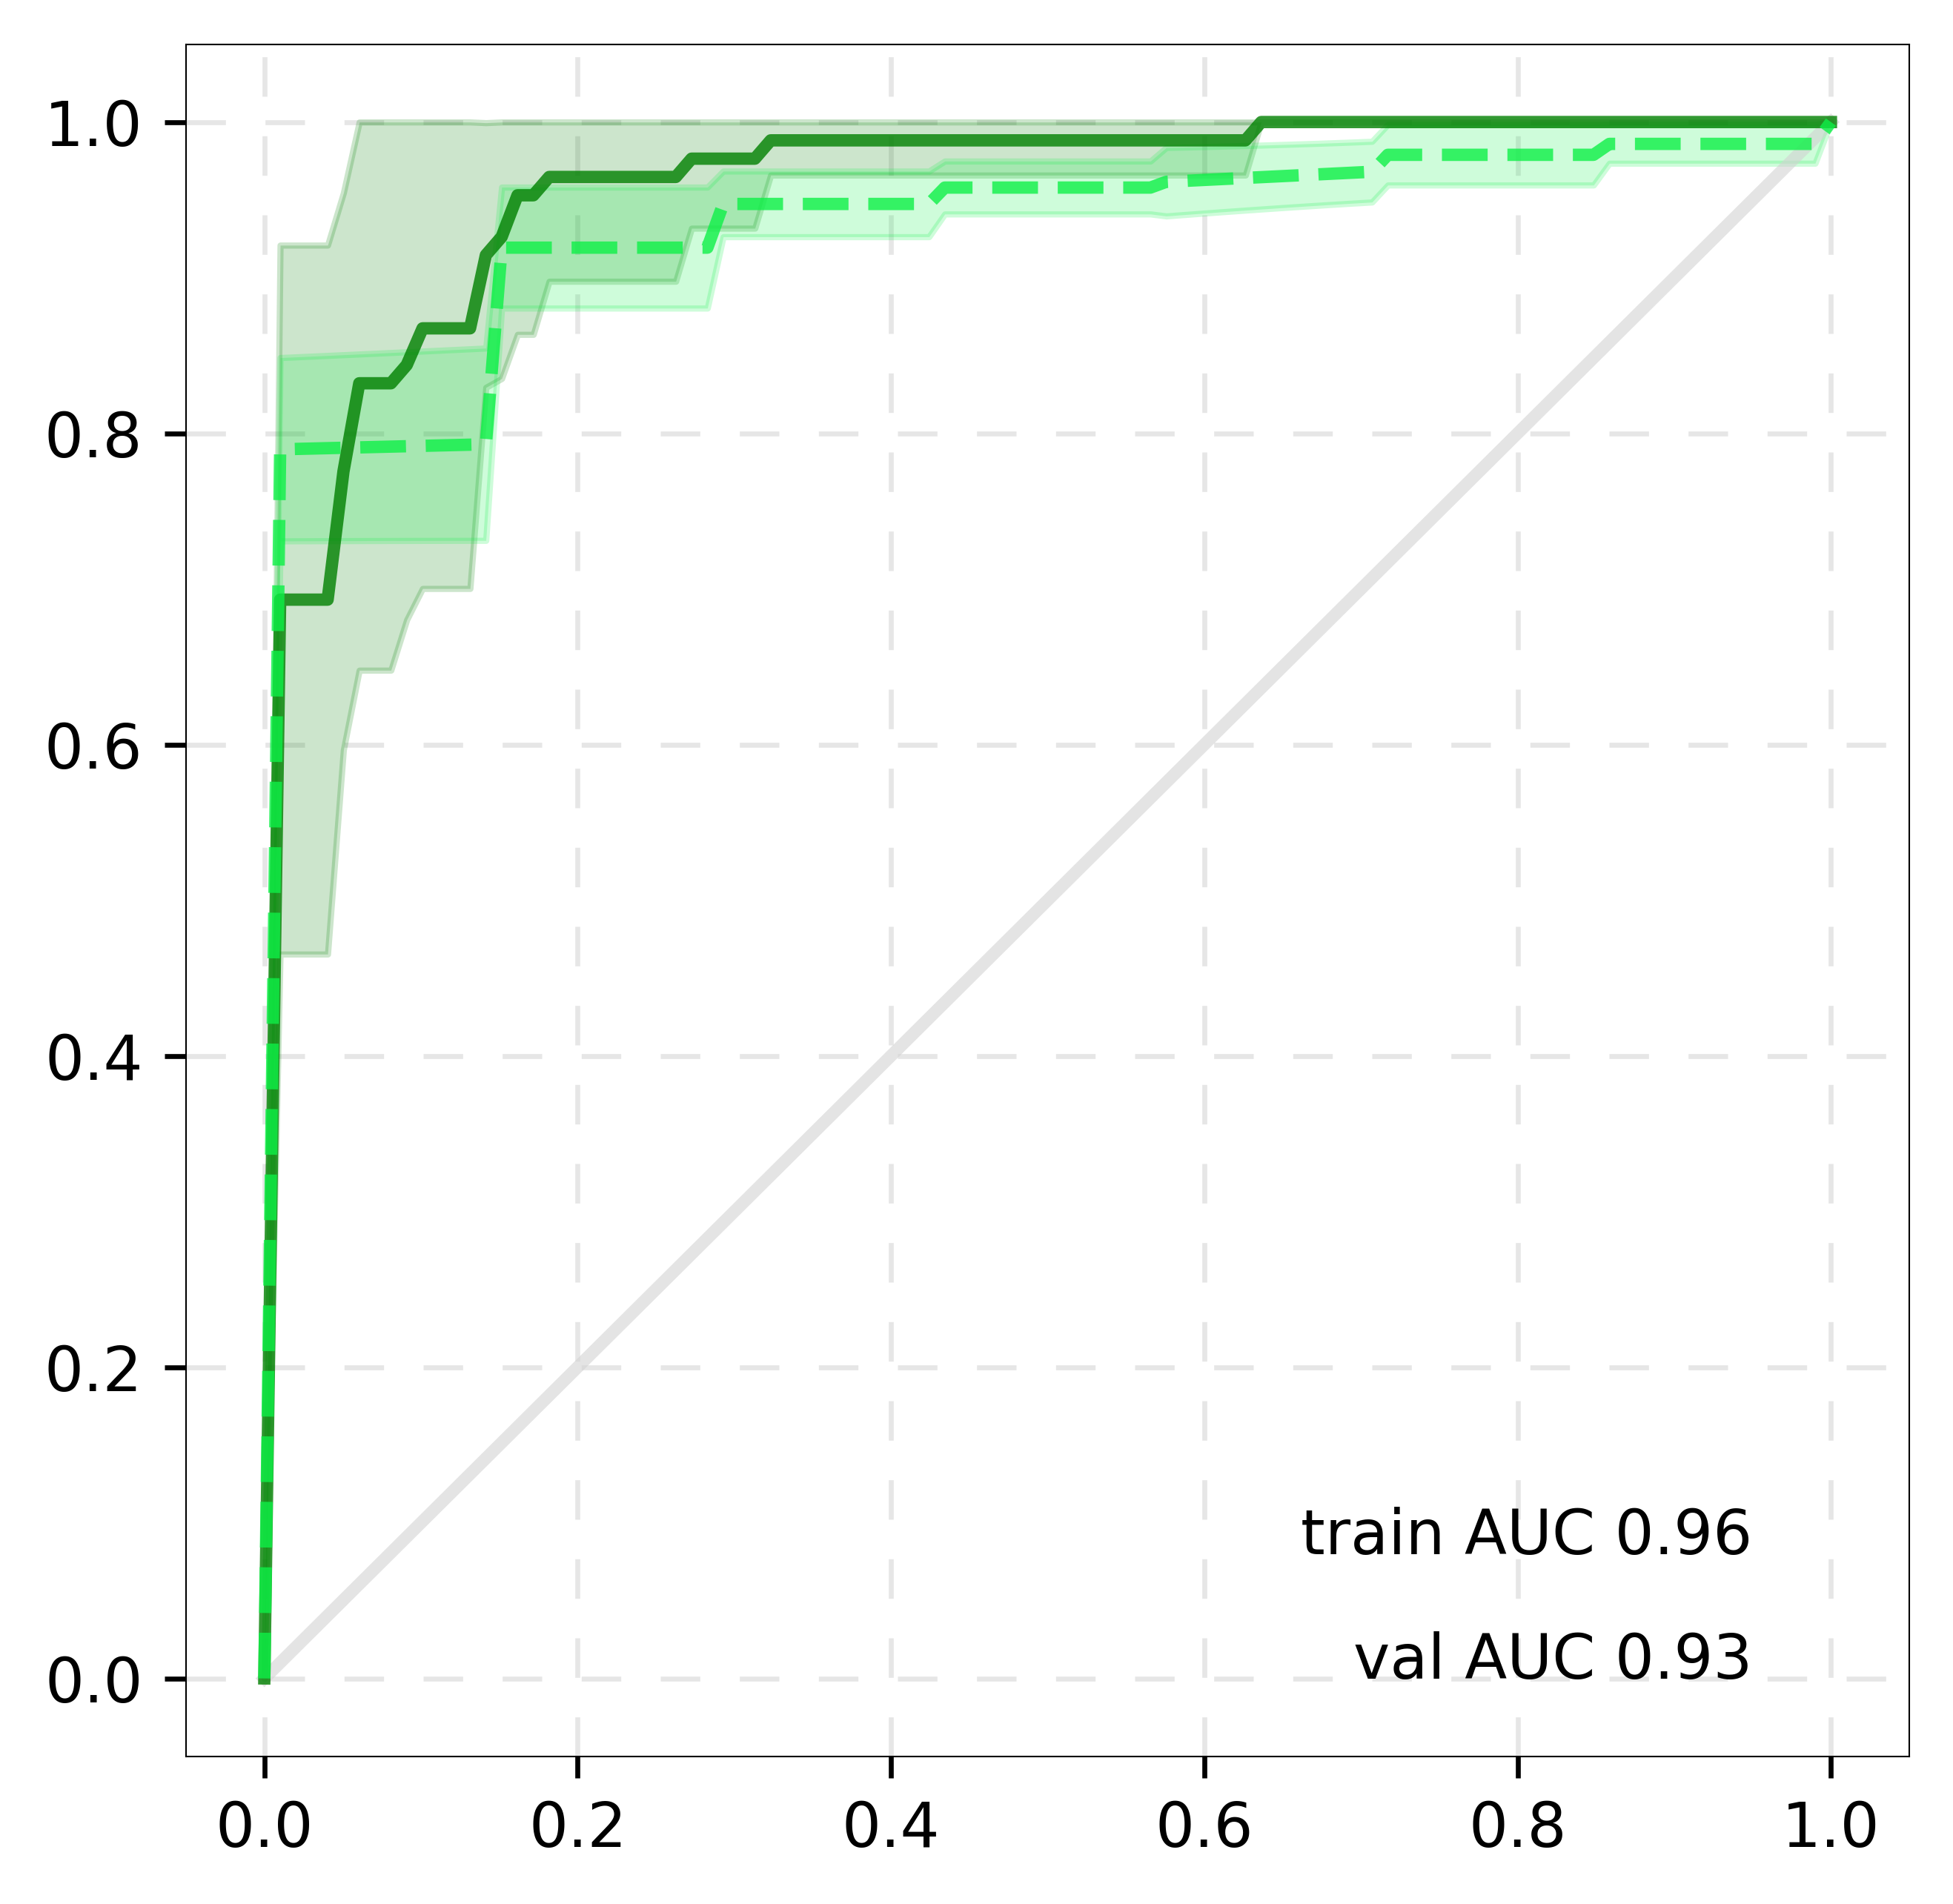

In [35]:
# all lipophilic metabolites
df_save = test_model(df_train_driftcorr_new, df_val_driftcorr_new, col_lipophilic_oeme, title=all_lip, modelname=modelname, drift=drift, hyper_param=hyper_param)
df_results = pd.concat([df_results,df_save])

In [36]:
# len of column list without the first two entries (id and label)
print('All suitable metabolites:', len(col_OEME)-2)
print('All hydrophilic metabolites', len(col_hydrophilic_oeme)-2)
print('All lipophilic metabolites', len(col_lipophilic_oeme)-2)

All suitable metabolites: 156
All hydrophilic metabolites 106
All lipophilic metabolites 53


### calculate random forest with not drift corrected data

In [37]:
drift = 'drift'

Results for rf and drift for all suitable metabolites(not drift corrected)
Train Sensitivity:  0.9487179487179487  Specificity:  0.7692307692307693  Accuracy:  0.8520710059171599  Balanced Accuracy:  0.858974358974359
Validation Sensitivity:  0.23148148148148145  Specificity:  0.9528301886792453  Accuracy:  0.709375  Balanced Accuracy:  0.5921558350803634
Joint Sensitivity:  0.532258064516129  Specificity:  0.8976897689768977  Accuracy:  0.7586912065439674  Balanced Accuracy:  0.7149739167465133


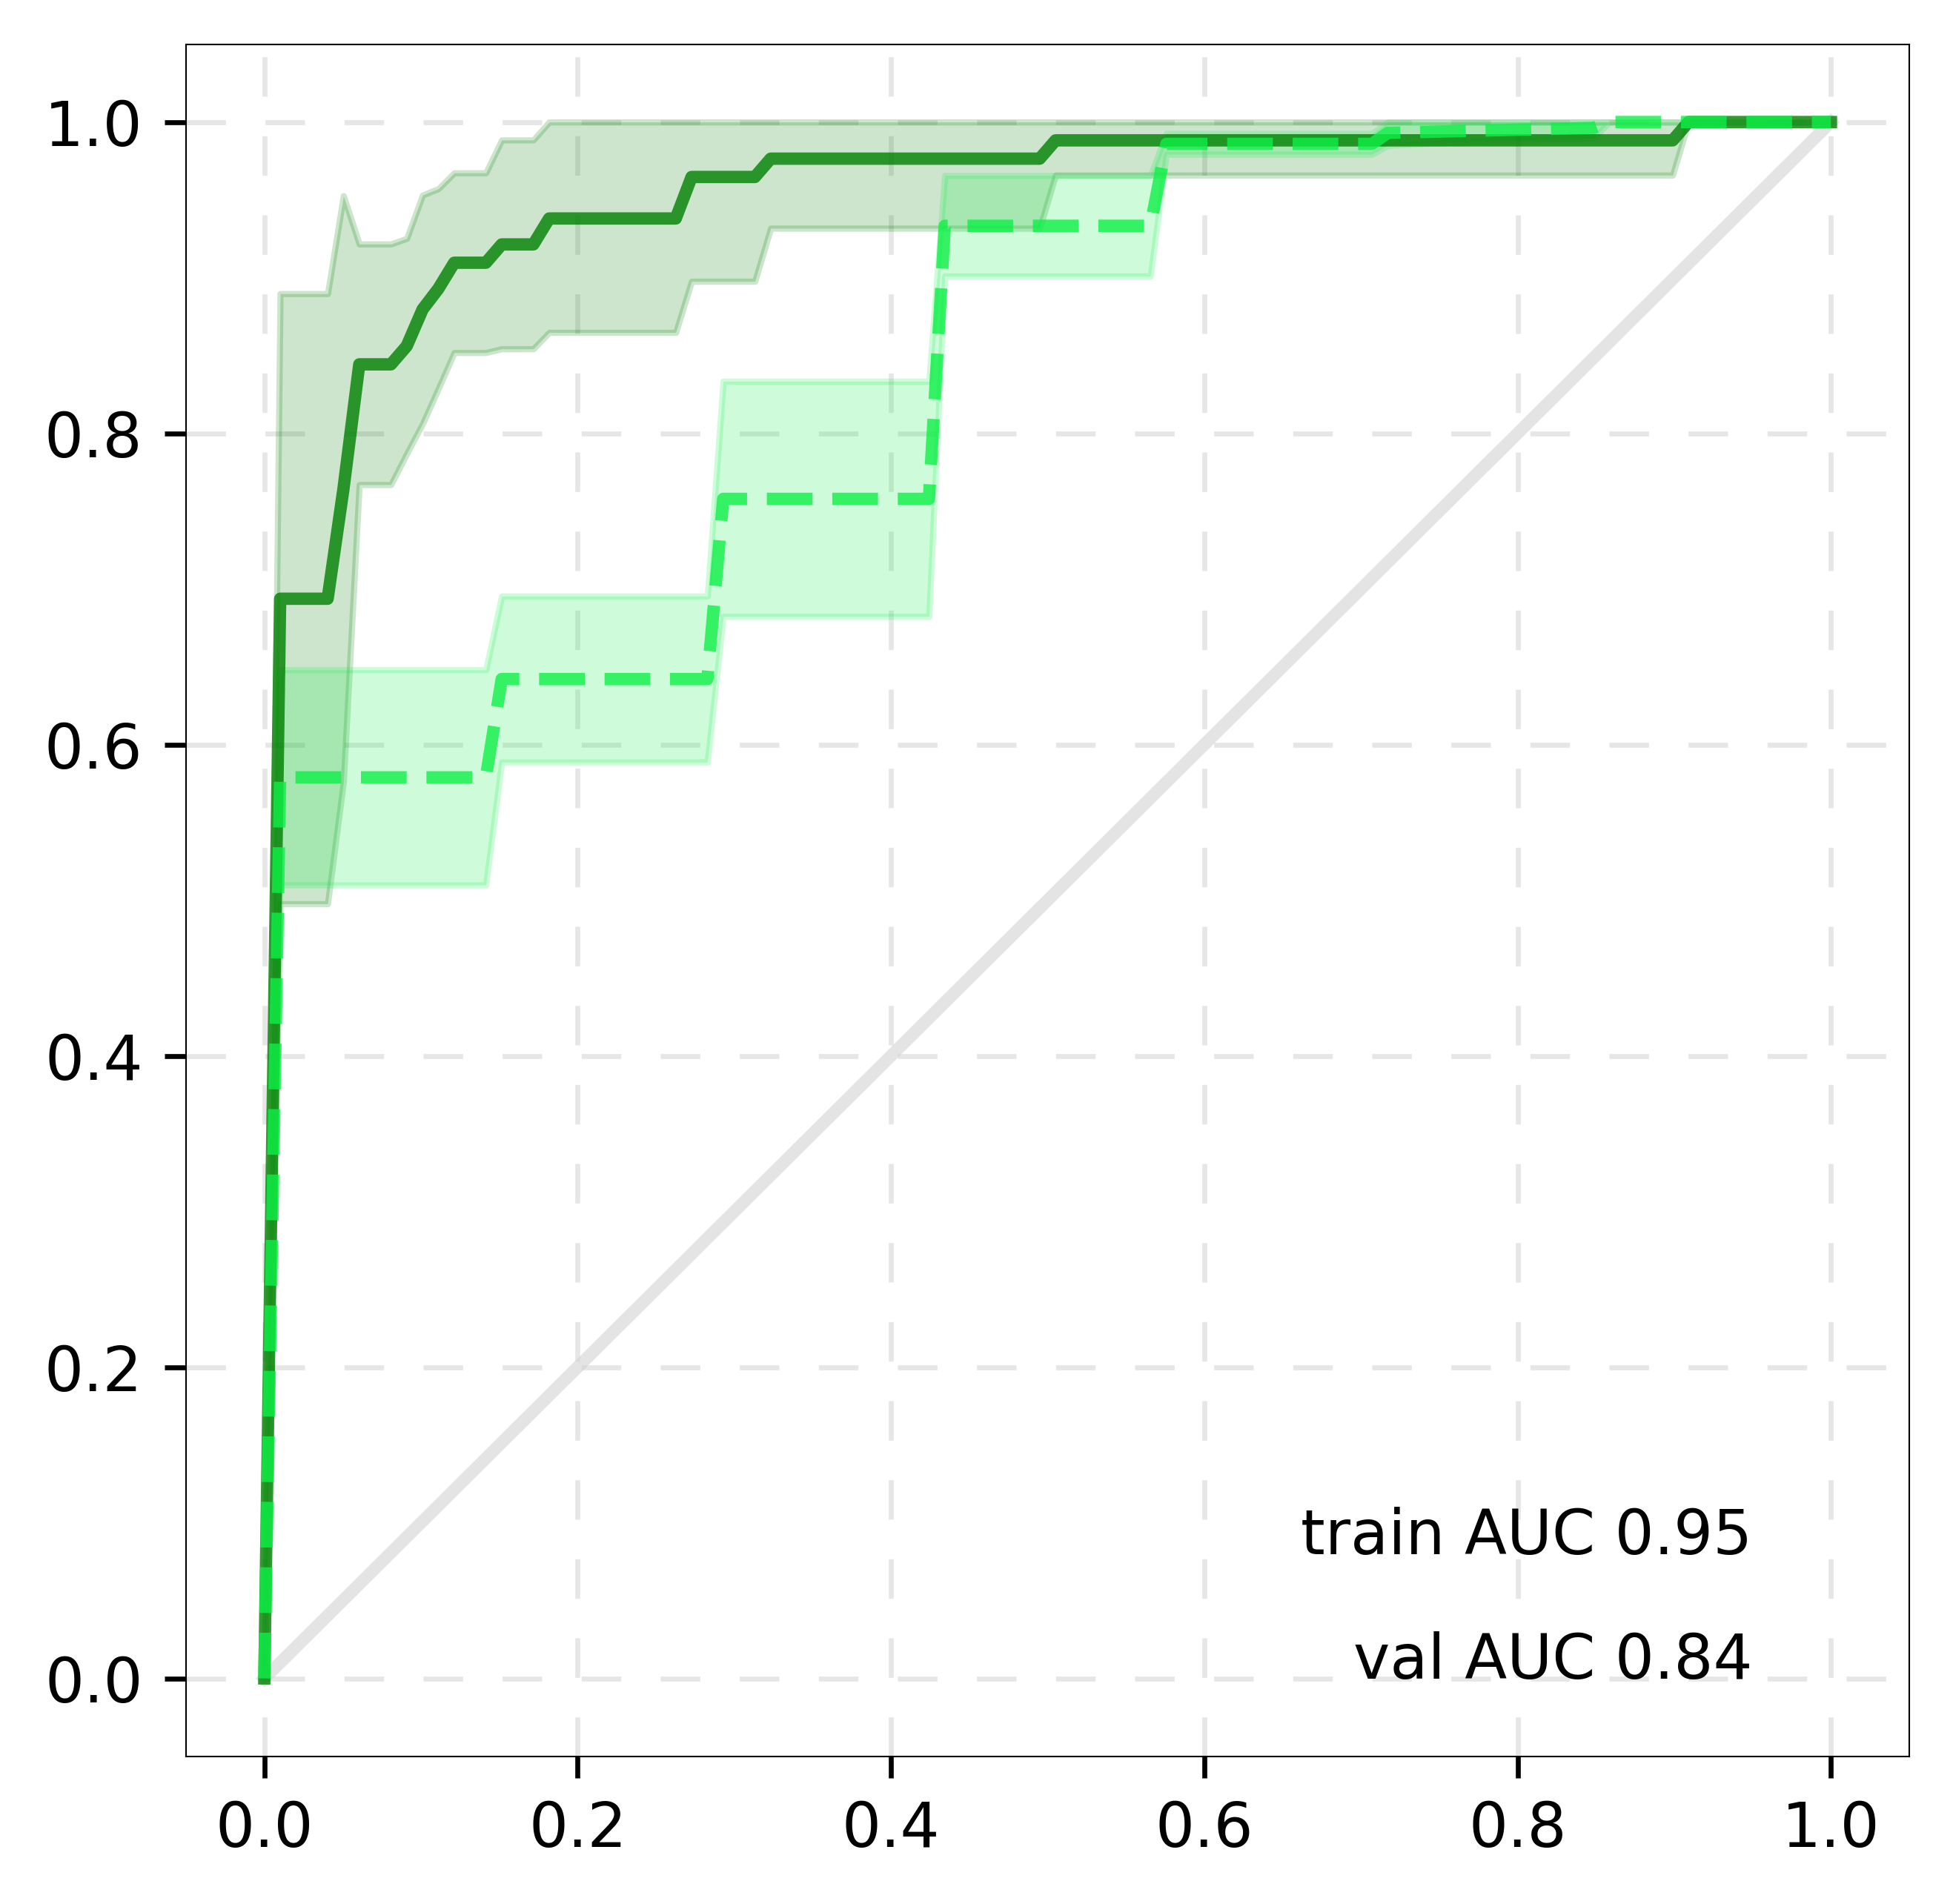

In [38]:
# all suitable metabolites
df_save = test_model(df_train_new, df_val_new, col_OE, title=all_metab+no_drift, modelname=modelname, drift=drift, hyper_param=hyper_param)
df_results = pd.concat([df_results,df_save])

Results for rf and drift for all hydrophilic metabolites(not drift corrected)
Train Sensitivity:  0.9125  Specificity:  0.7528089887640449  Accuracy:  0.8284023668639052  Balanced Accuracy:  0.8326544943820224
Validation Sensitivity:  0.20689655172413793  Specificity:  0.946078431372549  Accuracy:  0.678125  Balanced Accuracy:  0.5764874915483434
Joint Sensitivity:  0.4948979591836734  Specificity:  0.8873720136518771  Accuracy:  0.7300613496932515  Balanced Accuracy:  0.6911349864177753


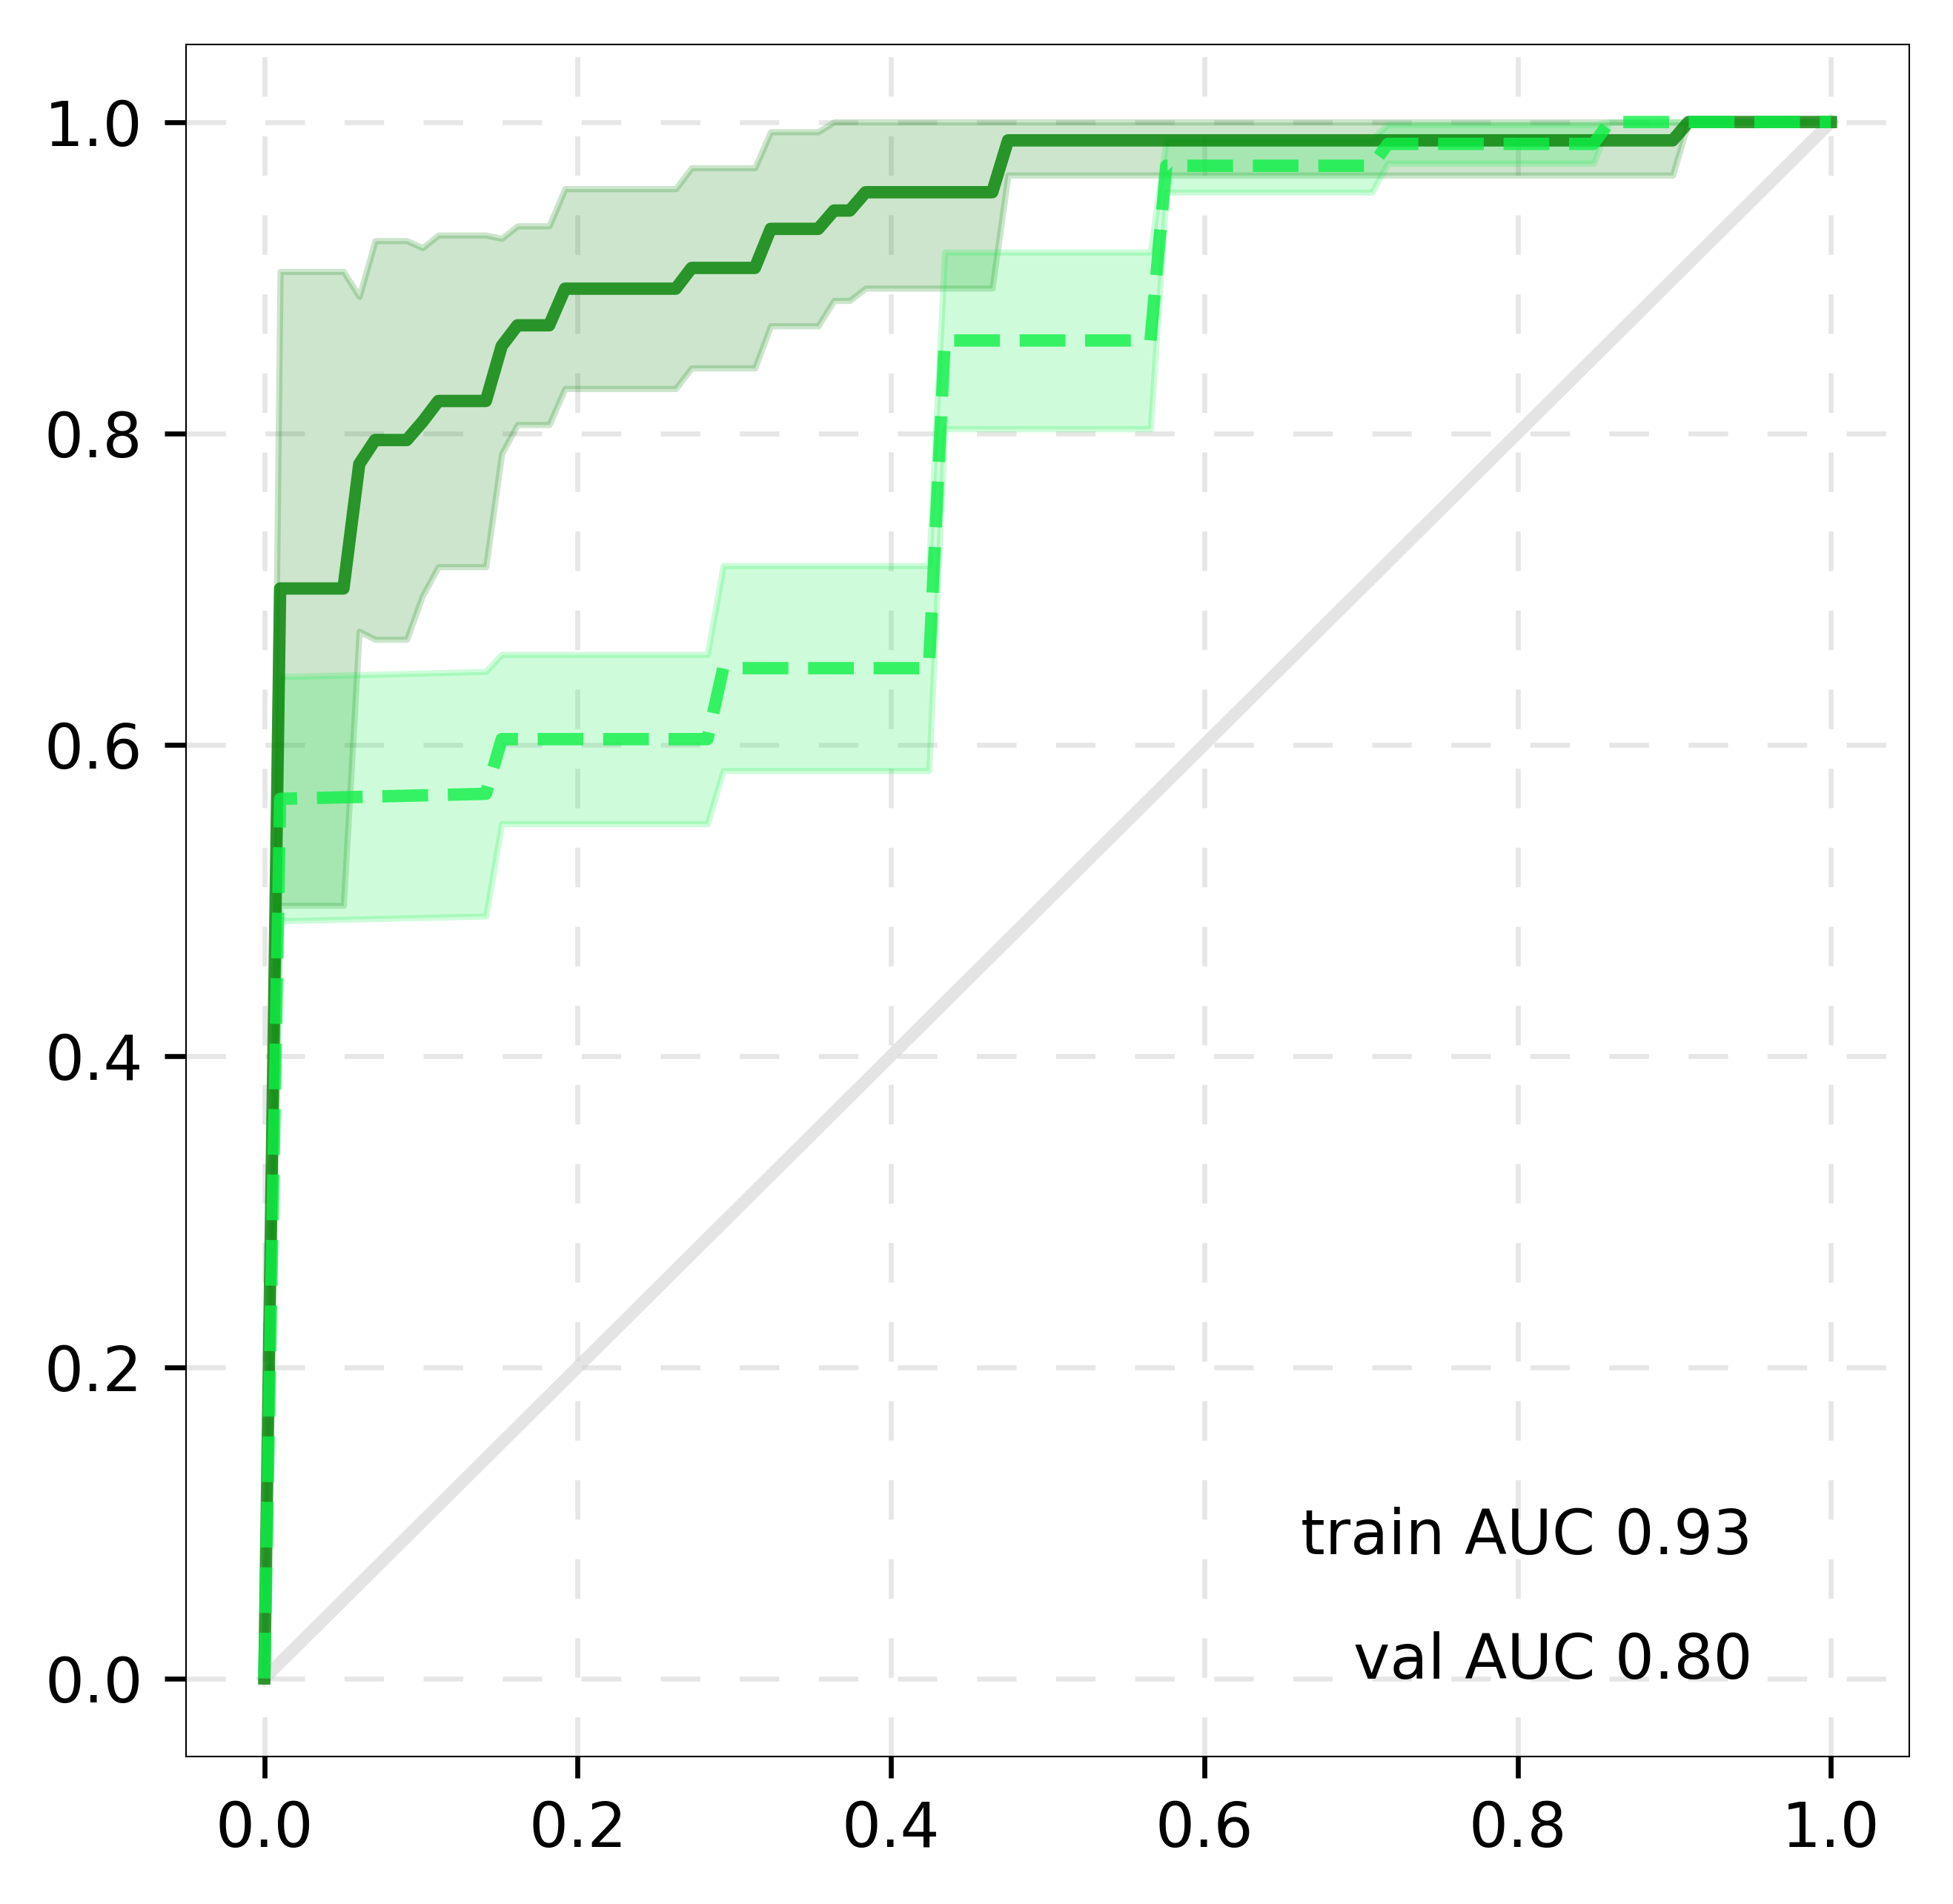

In [39]:
# all hydrophilic metabolites
df_save = test_model(df_train_new, df_val_new, col_hydrophilic_oe, title=all_hyd+no_drift, modelname=modelname, drift=drift, hyper_param=hyper_param)
df_results = pd.concat([df_results,df_save])

Results for rf and drift for all lipophilic FFAs&lipids(not drift corrected)
Train Sensitivity:  0.9210526315789475  Specificity:  0.7311827956989246  Accuracy:  0.8165680473372782  Balanced Accuracy:  0.826117713638936
Validation Sensitivity:  0.3229166666666667  Specificity:  0.9821428571428572  Accuracy:  0.784375  Balanced Accuracy:  0.652529761904762
Joint Sensitivity:  0.5872093023255814  Specificity:  0.9085173501577287  Accuracy:  0.7955010224948875  Balanced Accuracy:  0.7478633262416551


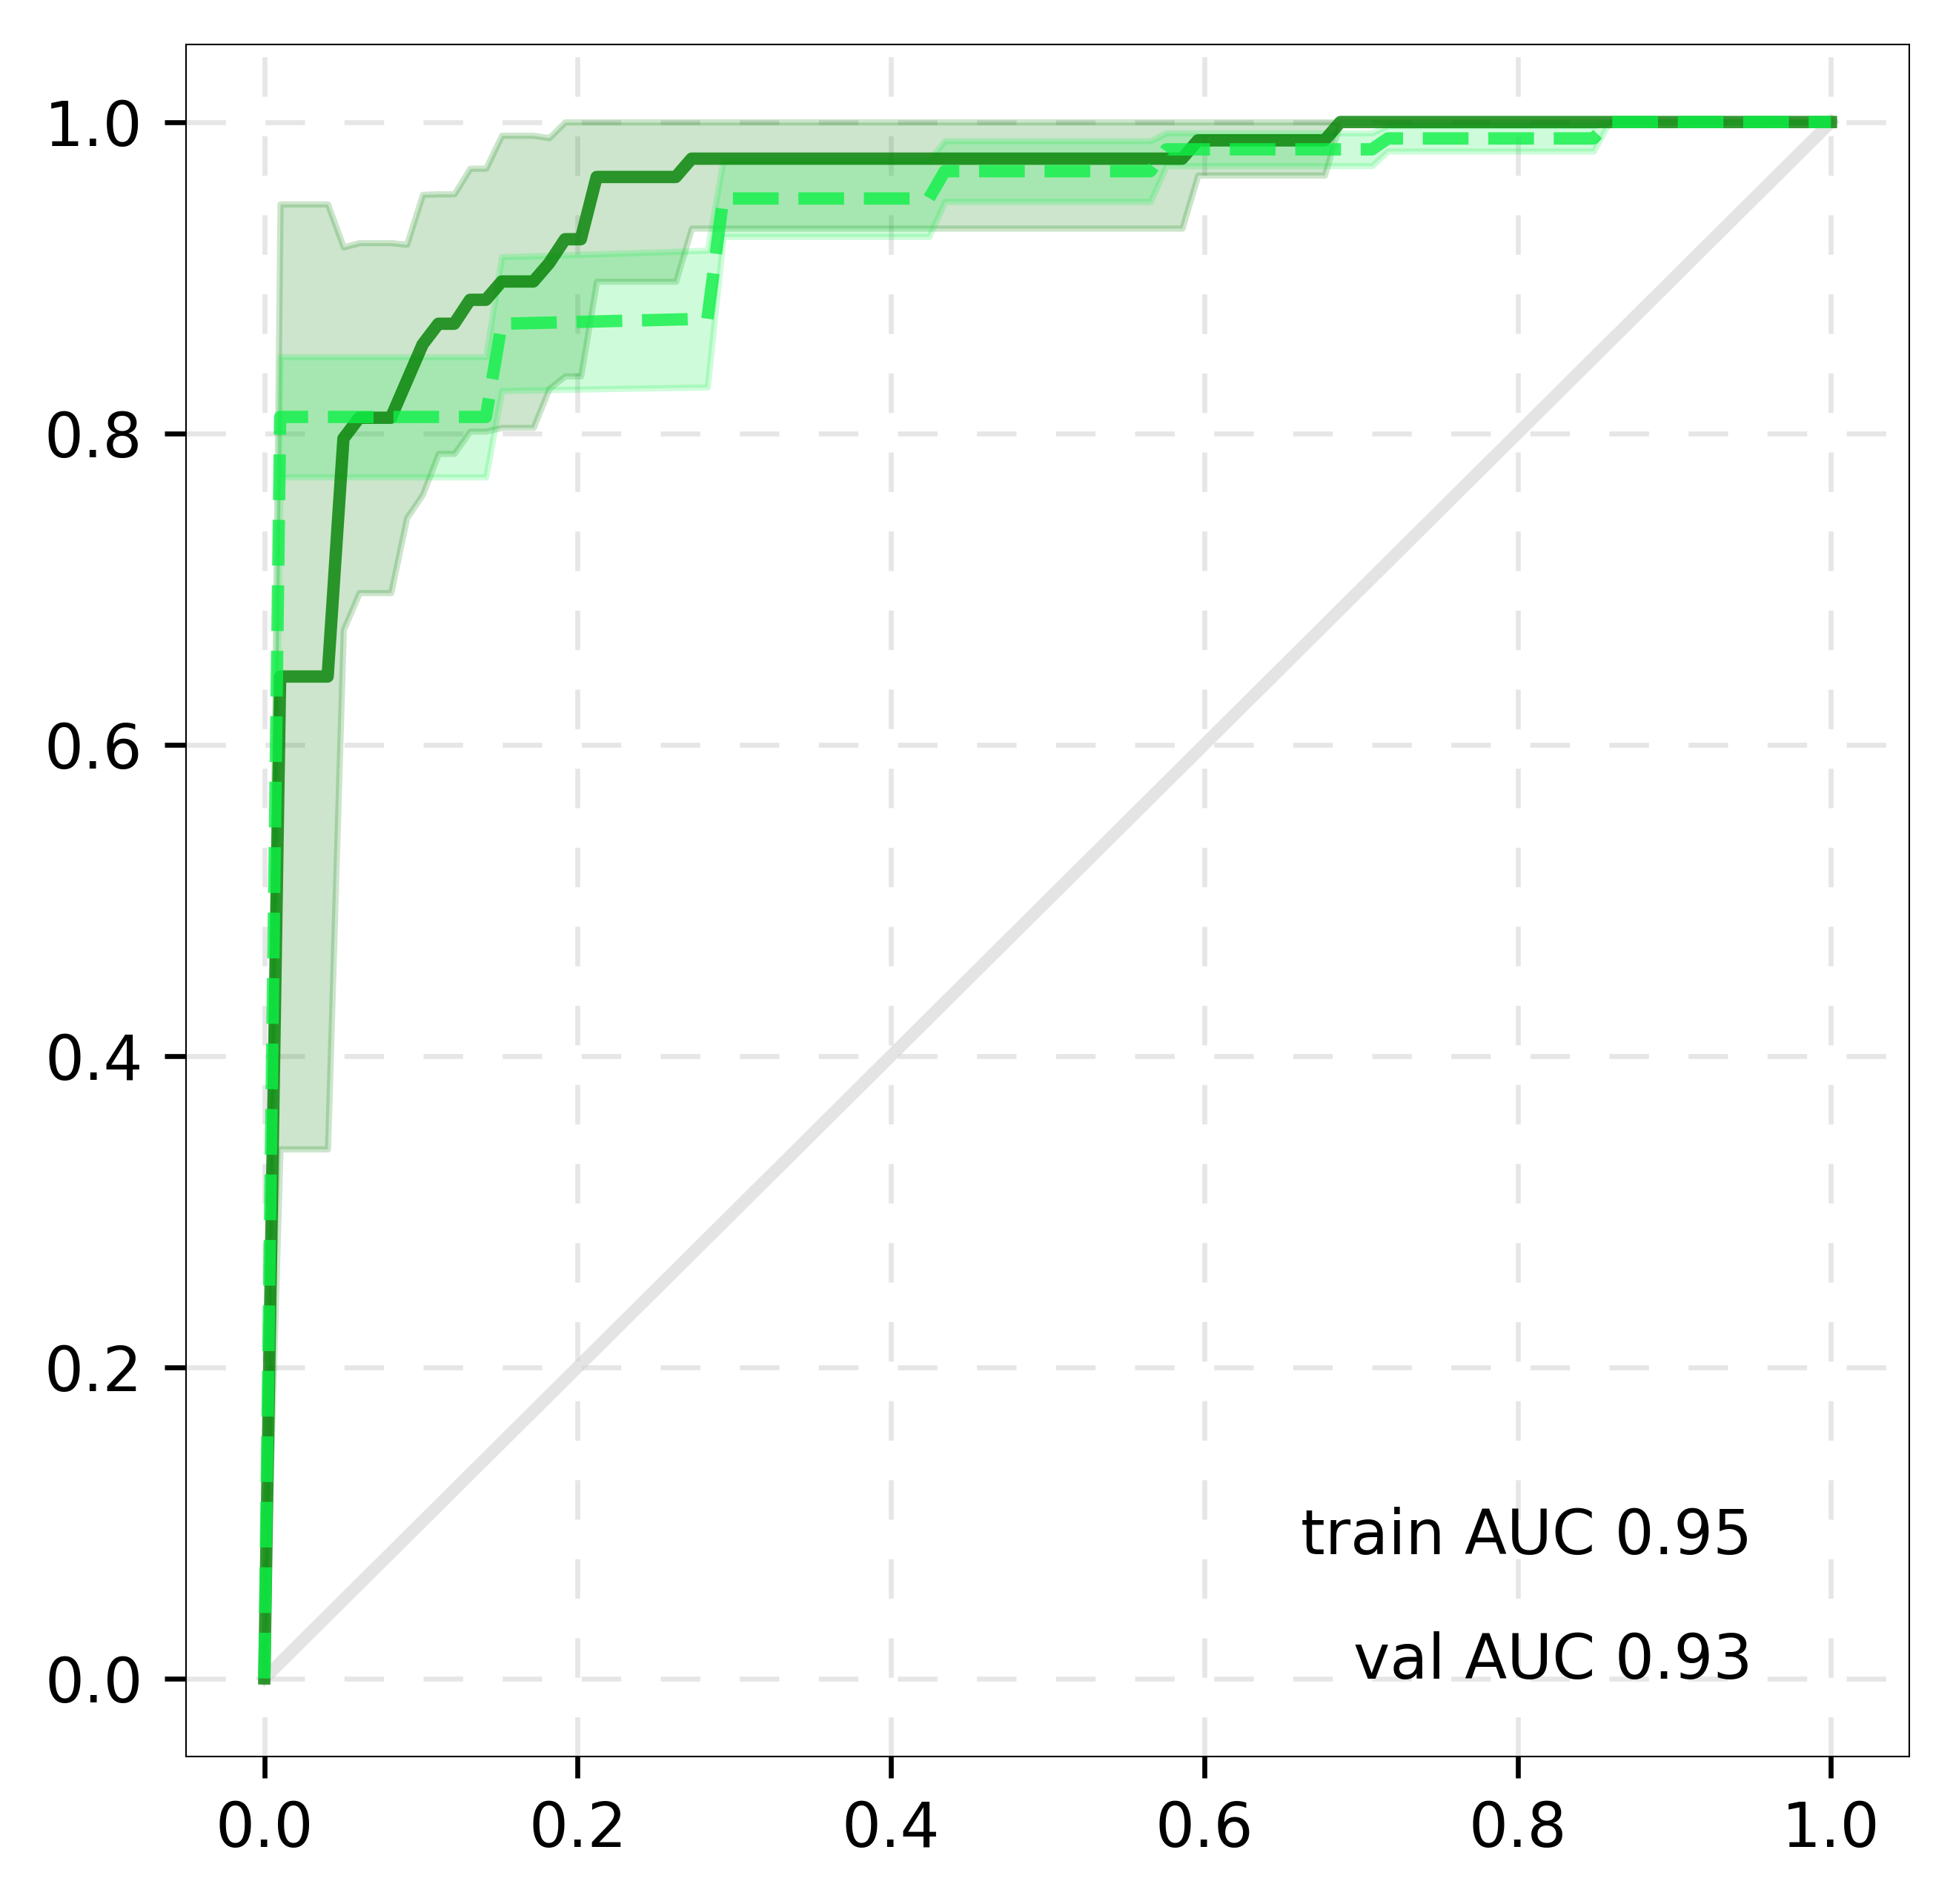

In [40]:
# all lipophilic metabolites
df_save = test_model(df_train_new, df_val_new, col_lipophilic_oe, title=all_lip+no_drift, modelname=modelname, drift=drift, hyper_param=hyper_param)
df_results = pd.concat([df_results,df_save])

### calculate XGB with drift corrected data

In [41]:
hyper_param = [0.01,5,3001]
modelname = 'xg'
drift='drift correction'

Results for xg and drift correction for all suitable metabolites
Train Sensitivity:  0.8686868686868686  Specificity:  0.8714285714285713  Accuracy:  0.8698224852071006  Balanced Accuracy:  0.87005772005772
Validation Sensitivity:  0.19230769230769232  Specificity:  1.0  Accuracy:  0.540625  Balanced Accuracy:  0.5961538461538461
Joint Sensitivity:  0.43060498220640564  Specificity:  0.9567307692307693  Accuracy:  0.65439672801636  Balanced Accuracy:  0.6936678757185875


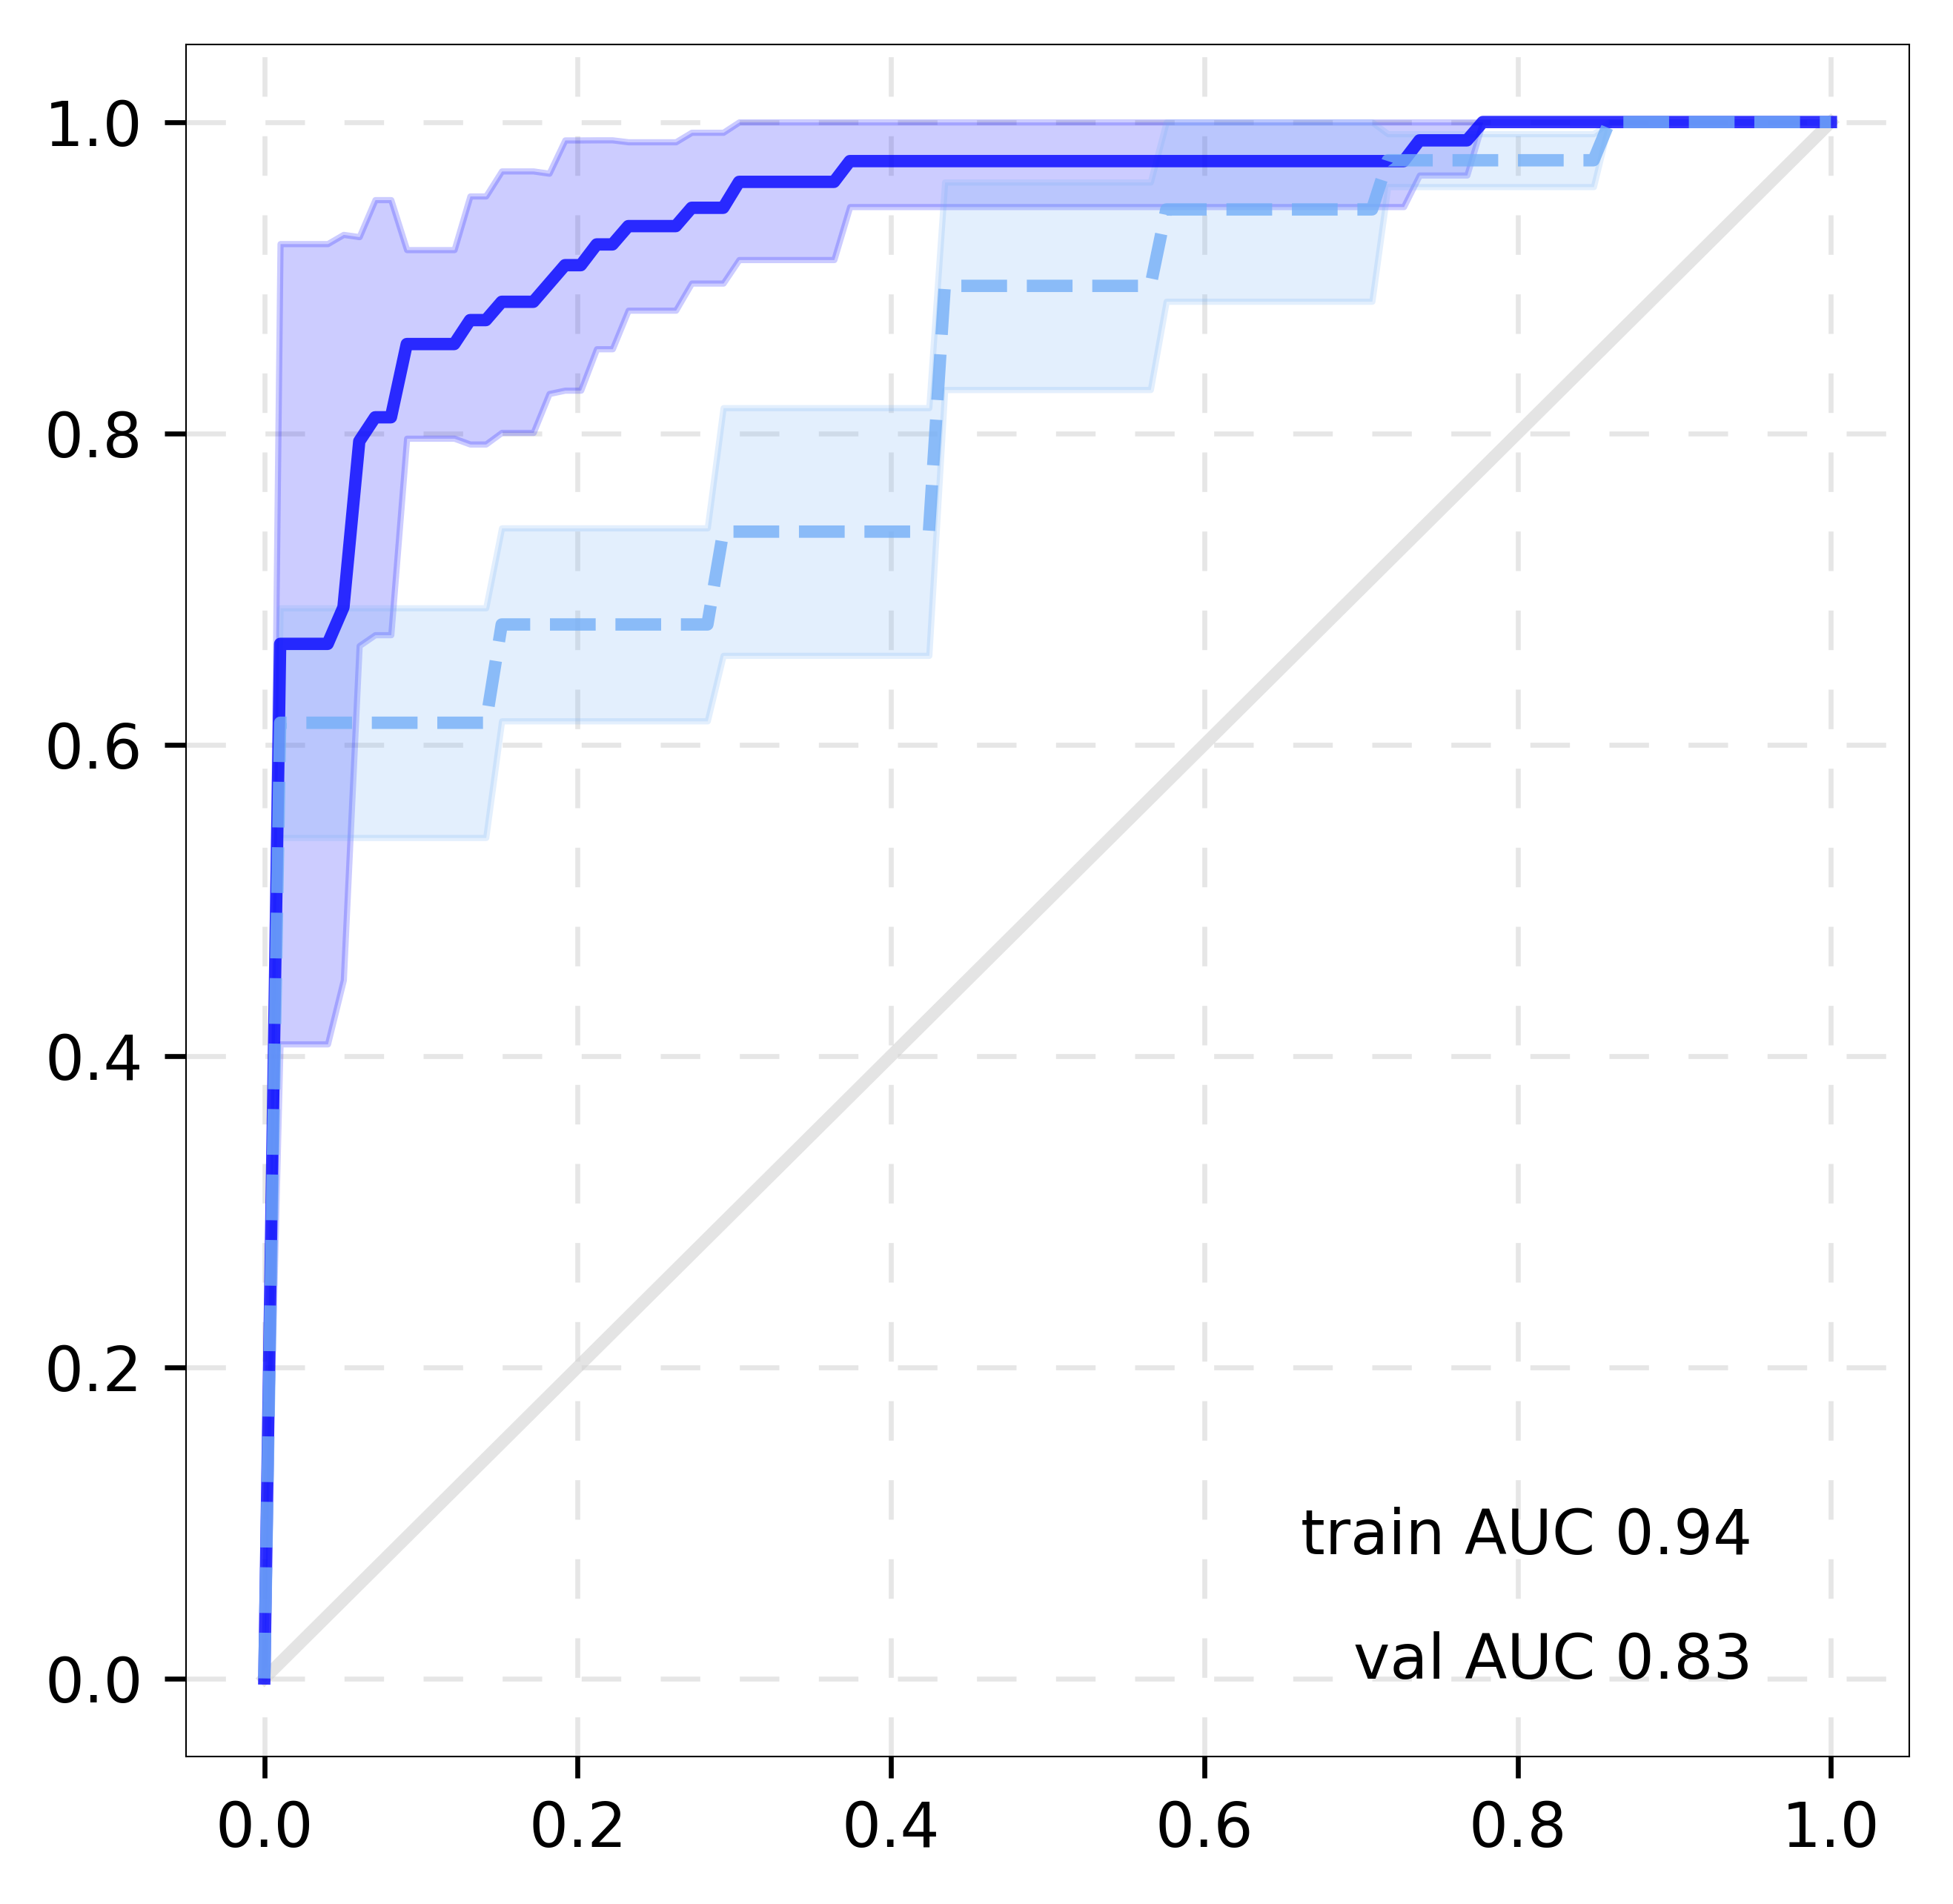

In [42]:
# all suitable metabolites
df_save = test_model(df_train_driftcorr_new, df_val_driftcorr_new, col_OEME, title=all_metab, modelname=modelname, drift=drift, hyper_param=hyper_param)
df_results = pd.concat([df_results,df_save])

only metabolites

Results for xg and drift correction for all hydrophilic metabolites
Train Sensitivity:  0.8469387755102041  Specificity:  0.8309859154929577  Accuracy:  0.8402366863905325  Balanced Accuracy:  0.8389623455015809
Validation Sensitivity:  0.19886363636363635  Specificity:  1.0  Accuracy:  0.559375  Balanced Accuracy:  0.5994318181818181
Joint Sensitivity:  0.43065693430656937  Specificity:  0.944186046511628  Accuracy:  0.656441717791411  Balanced Accuracy:  0.6874214904090987


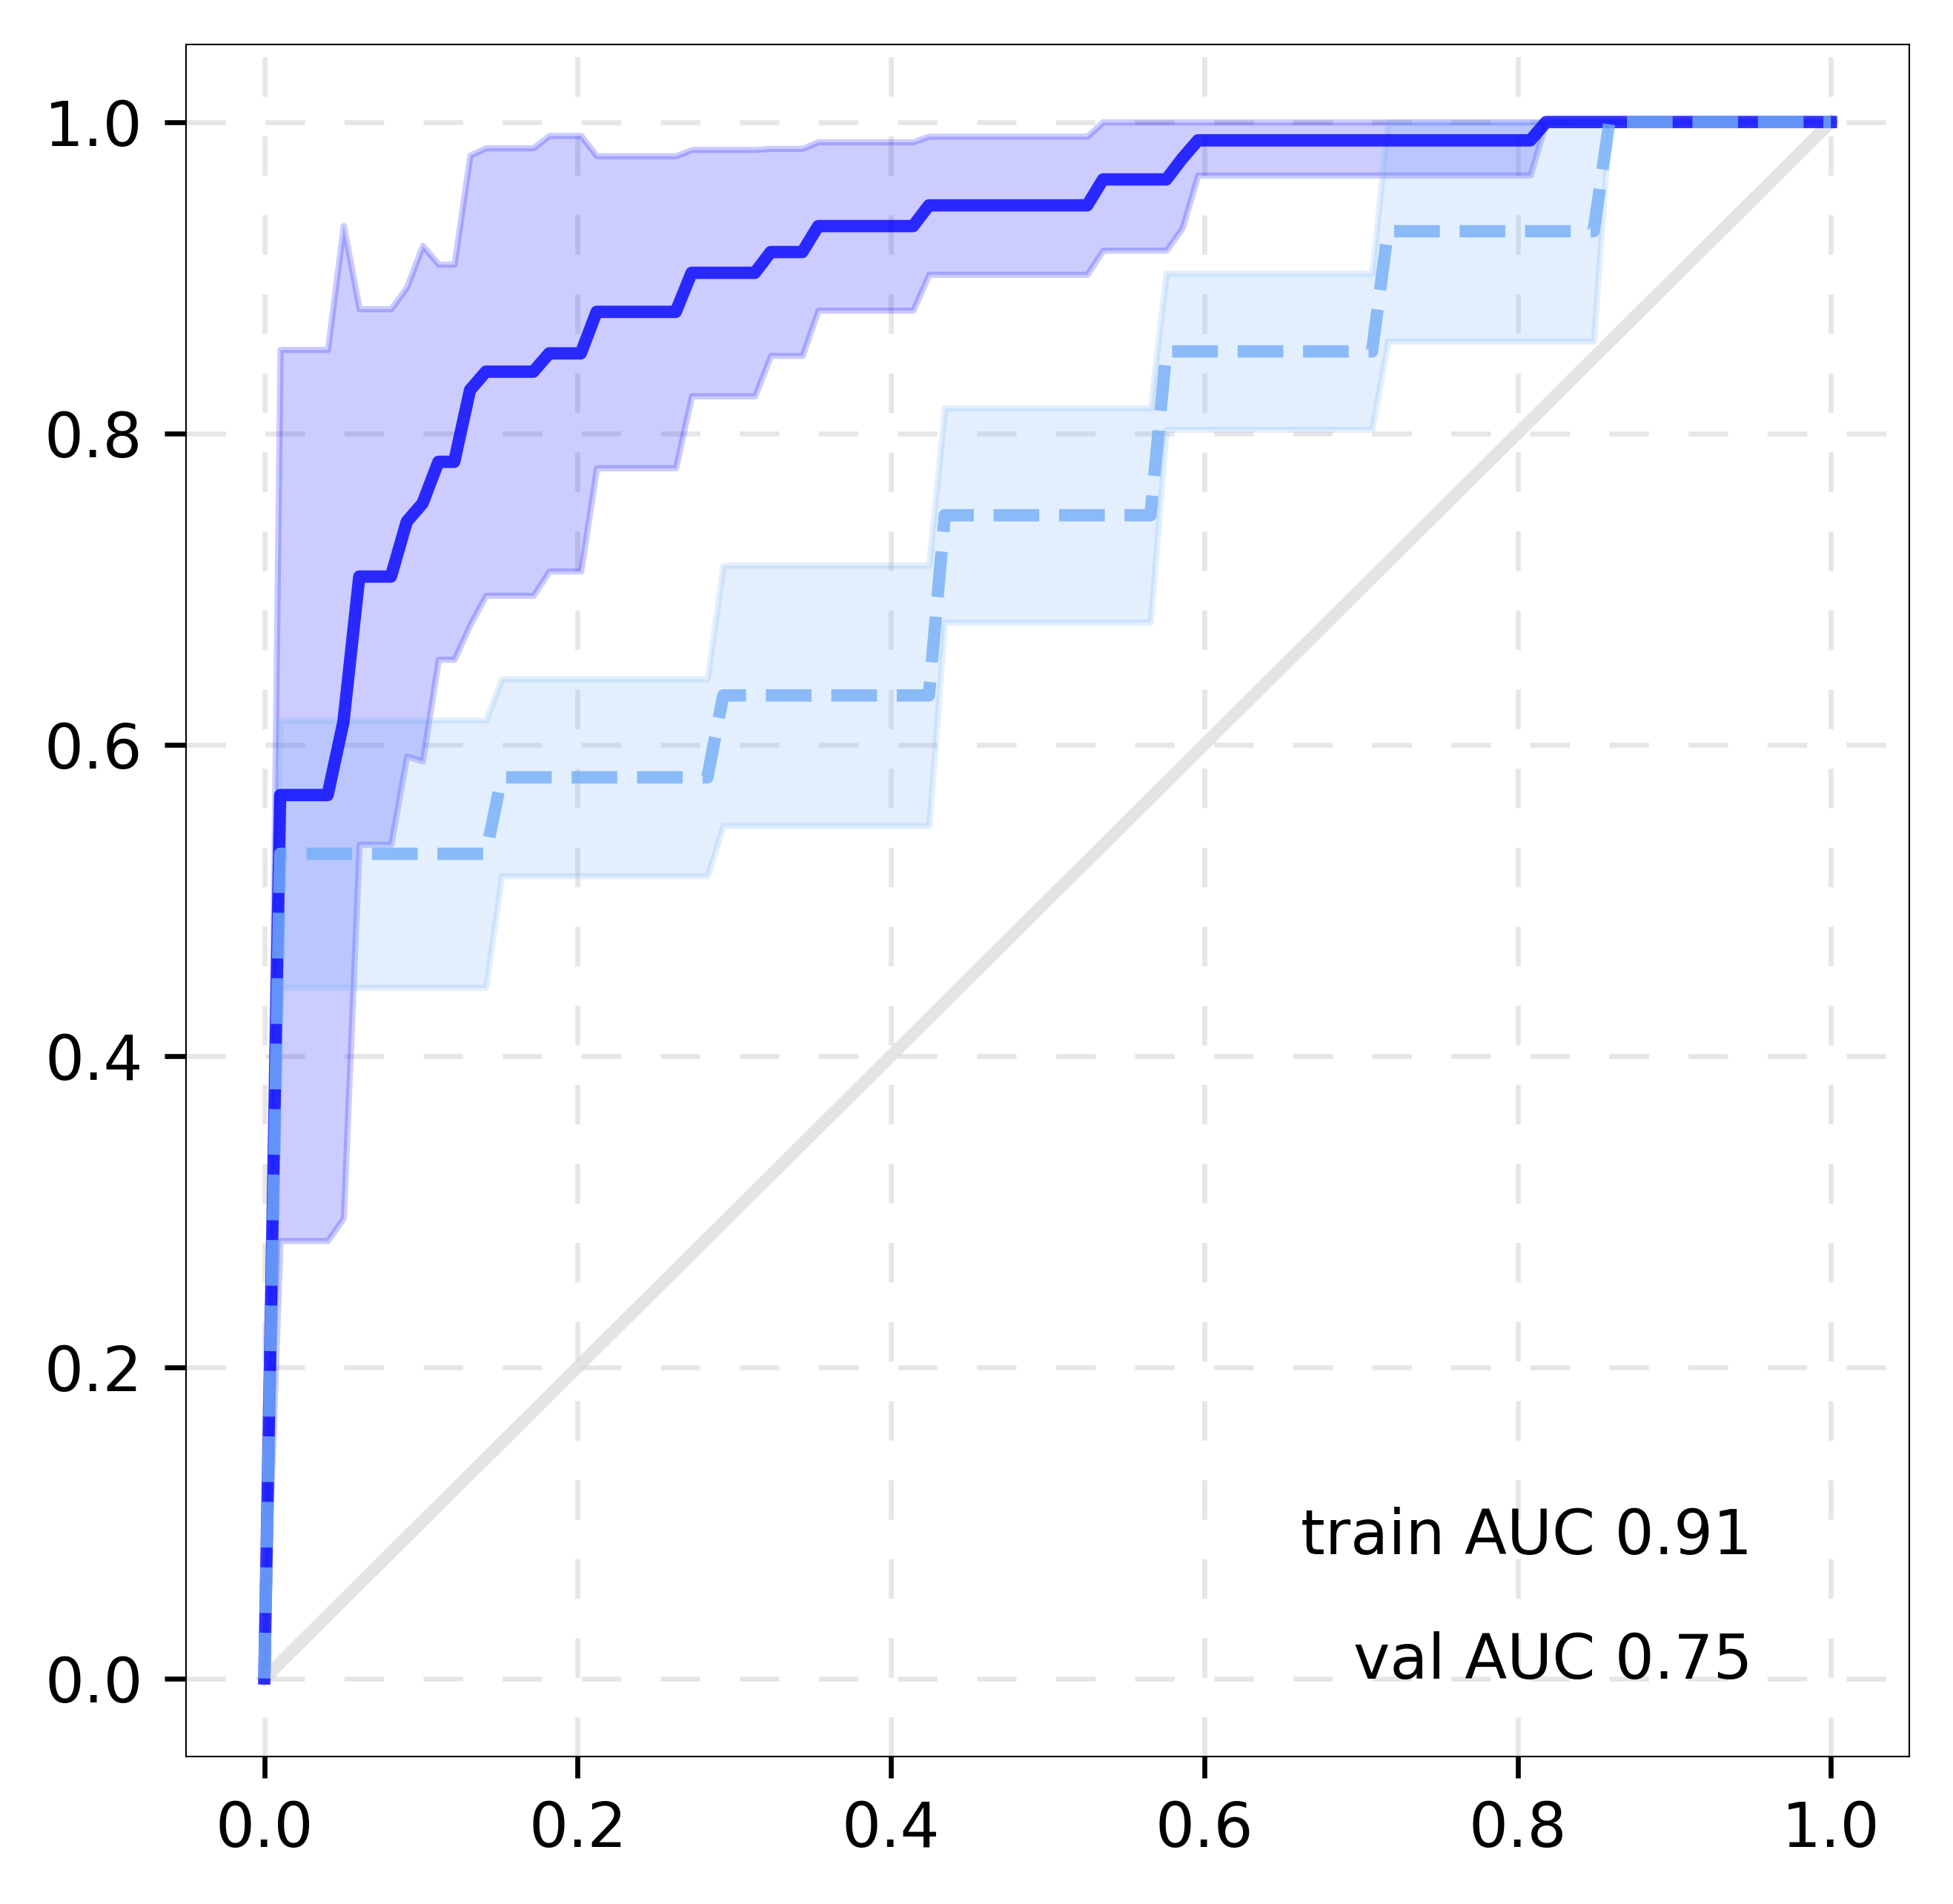

In [43]:
# all hydrophilic metabolites
df_save = test_model(df_train_driftcorr_new, df_val_driftcorr_new, col_hydrophilic_oeme, title=all_hyd, modelname=modelname, drift=drift, hyper_param=hyper_param)
df_results = pd.concat([df_results,df_save])

no metabolites

Results for xg and drift correction for all lipophilic FFAs&lipids
Train Sensitivity:  0.8400000000000001  Specificity:  0.8405797101449275  Accuracy:  0.8402366863905326  Balanced Accuracy:  0.8402898550724638
Validation Sensitivity:  0.18041237113402064  Specificity:  1.0  Accuracy:  0.503125  Balanced Accuracy:  0.5902061855670103
Joint Sensitivity:  0.40476190476190477  Specificity:  0.9435897435897436  Accuracy:  0.6196319018404908  Balanced Accuracy:  0.6741758241758242


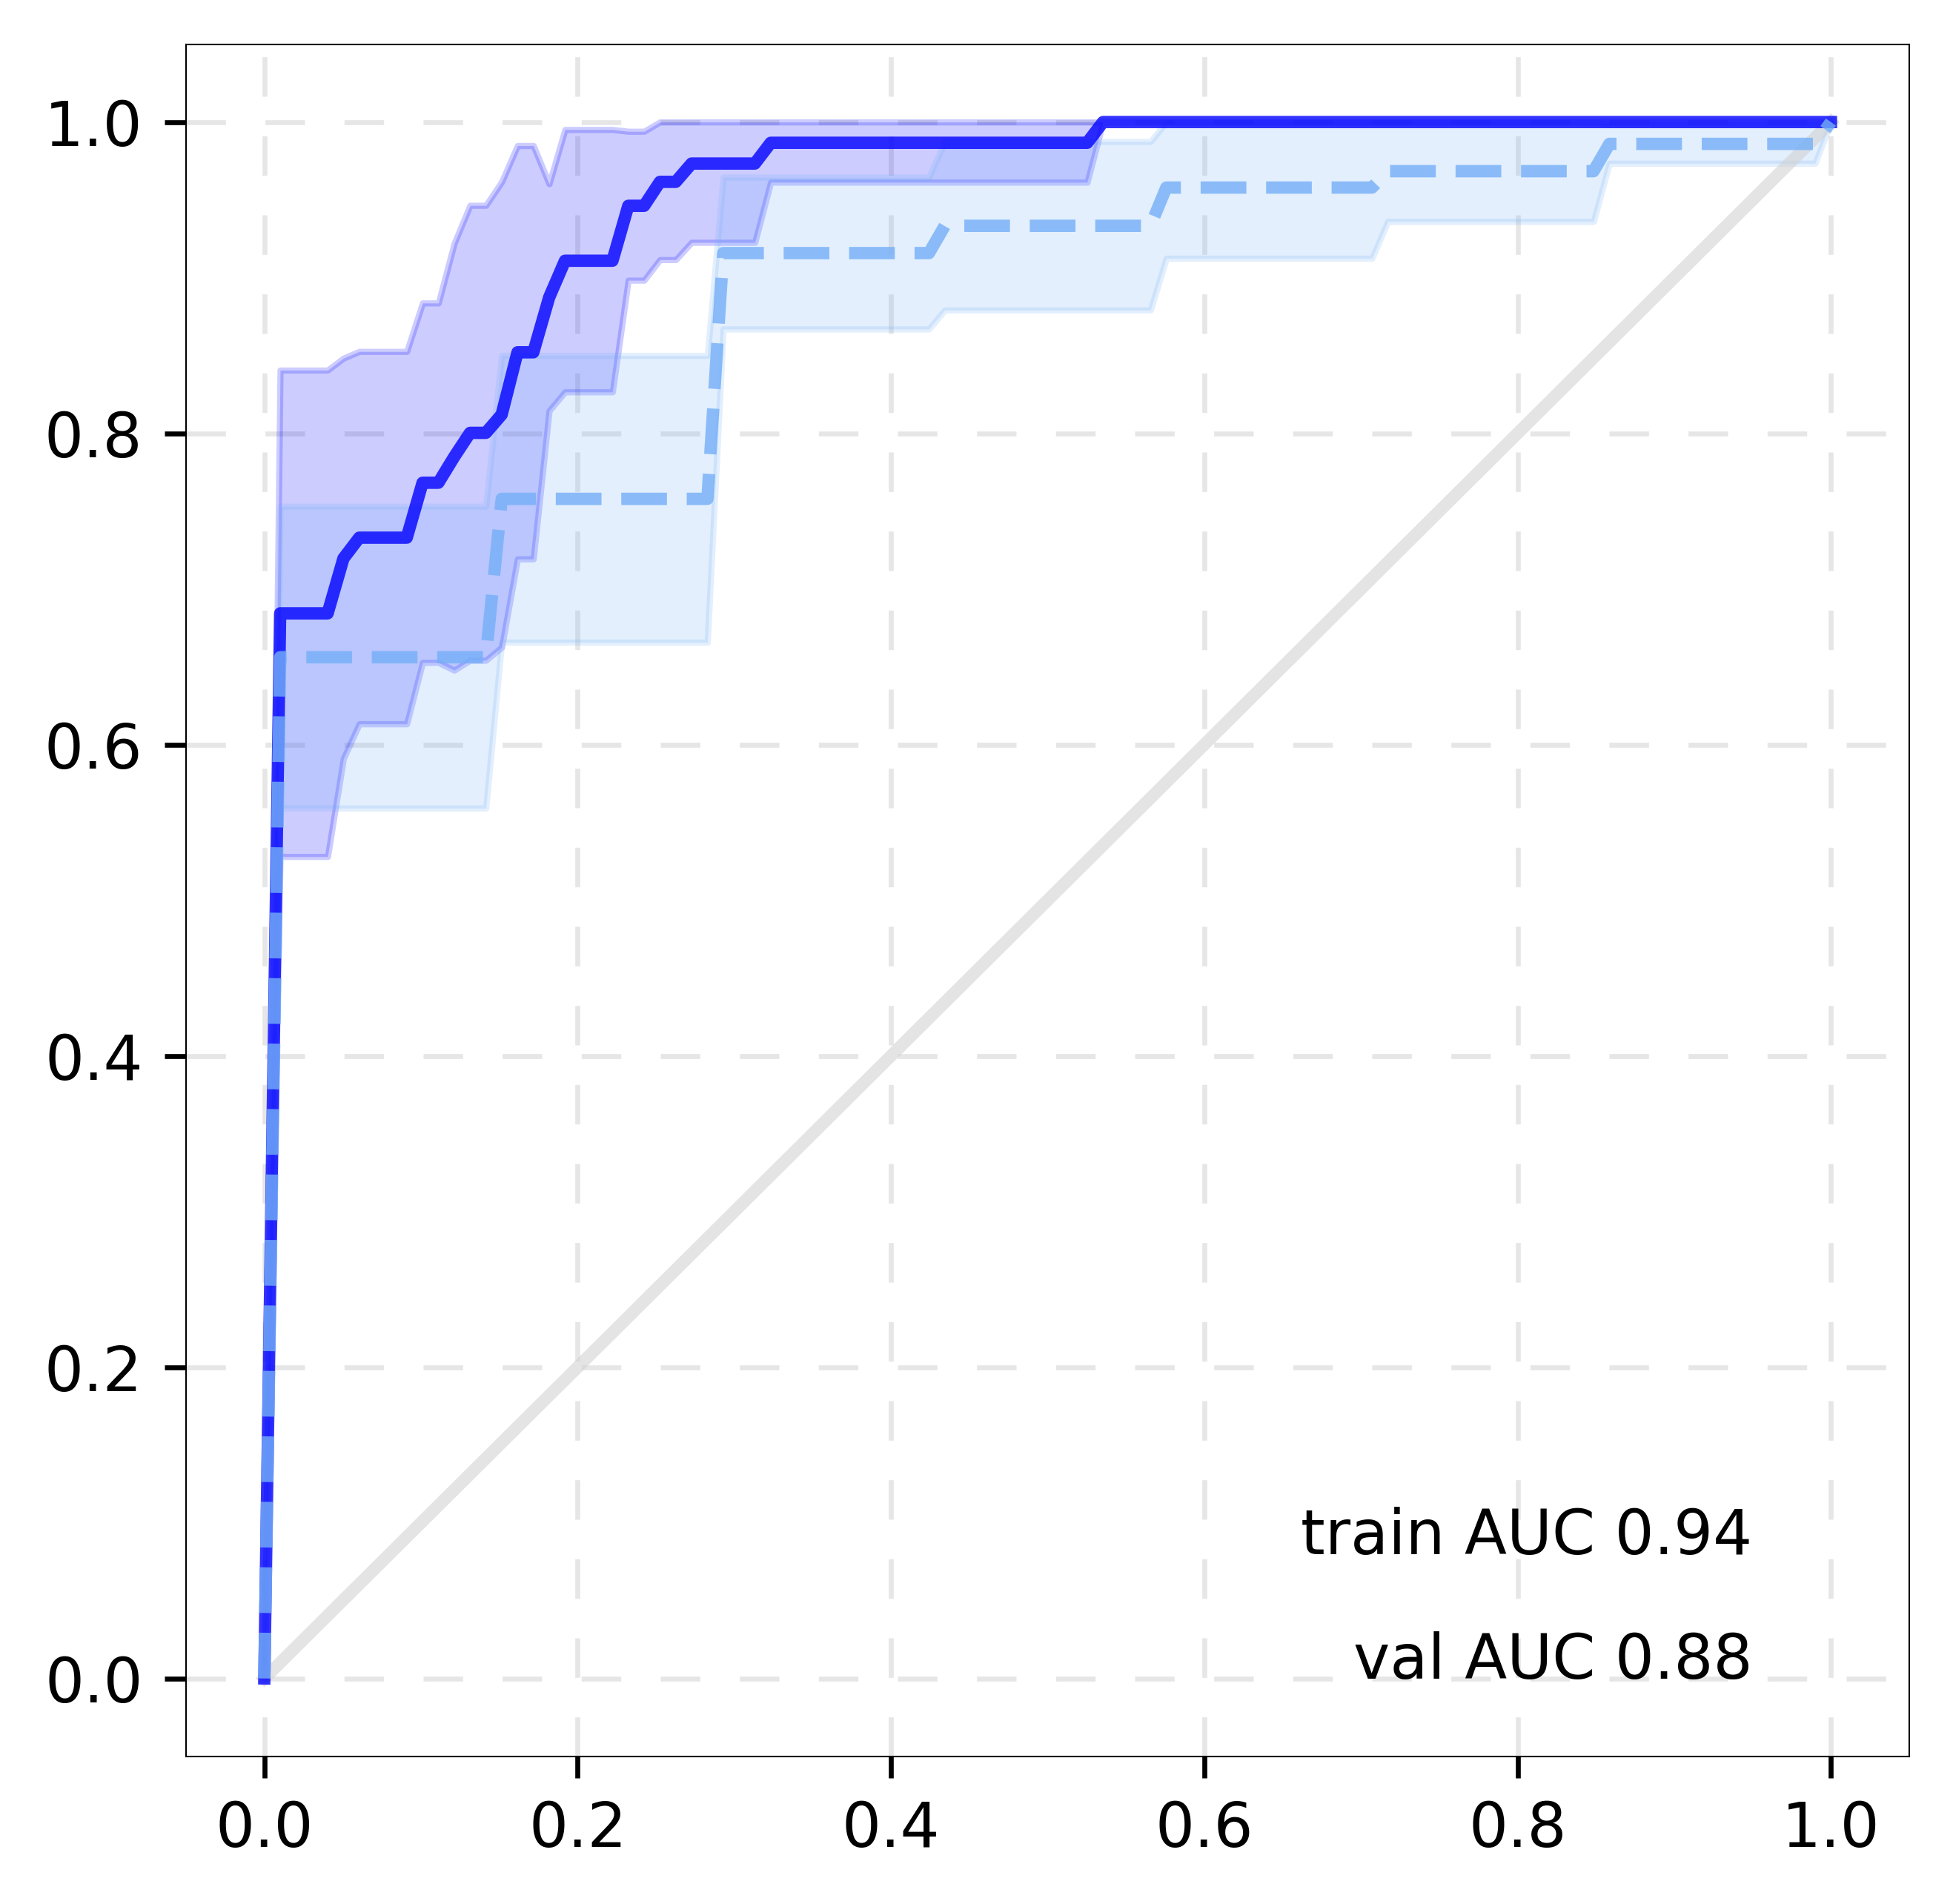

In [44]:
# all lipophilic metabolites
df_save = test_model(df_train_driftcorr_new, df_val_driftcorr_new, col_lipophilic_oeme, title=all_lip, modelname=modelname, drift=drift, hyper_param=hyper_param)
df_results = pd.concat([df_results,df_save])

### calculate XGB with not drift corrected data

In [45]:
drift='drift'

Results for xg and drift for all suitable metabolites(not drift corrected)
Train Sensitivity:  0.9342105263157895  Specificity:  0.7419354838709677  Accuracy:  0.8284023668639054  Balanced Accuracy:  0.8380730050933787
Validation Sensitivity:  0.27184466019417475  Specificity:  0.967741935483871  Accuracy:  0.74375  Balanced Accuracy:  0.6197932978390228
Joint Sensitivity:  0.553072625698324  Specificity:  0.8999999999999999  Accuracy:  0.7730061349693251  Balanced Accuracy:  0.726536312849162


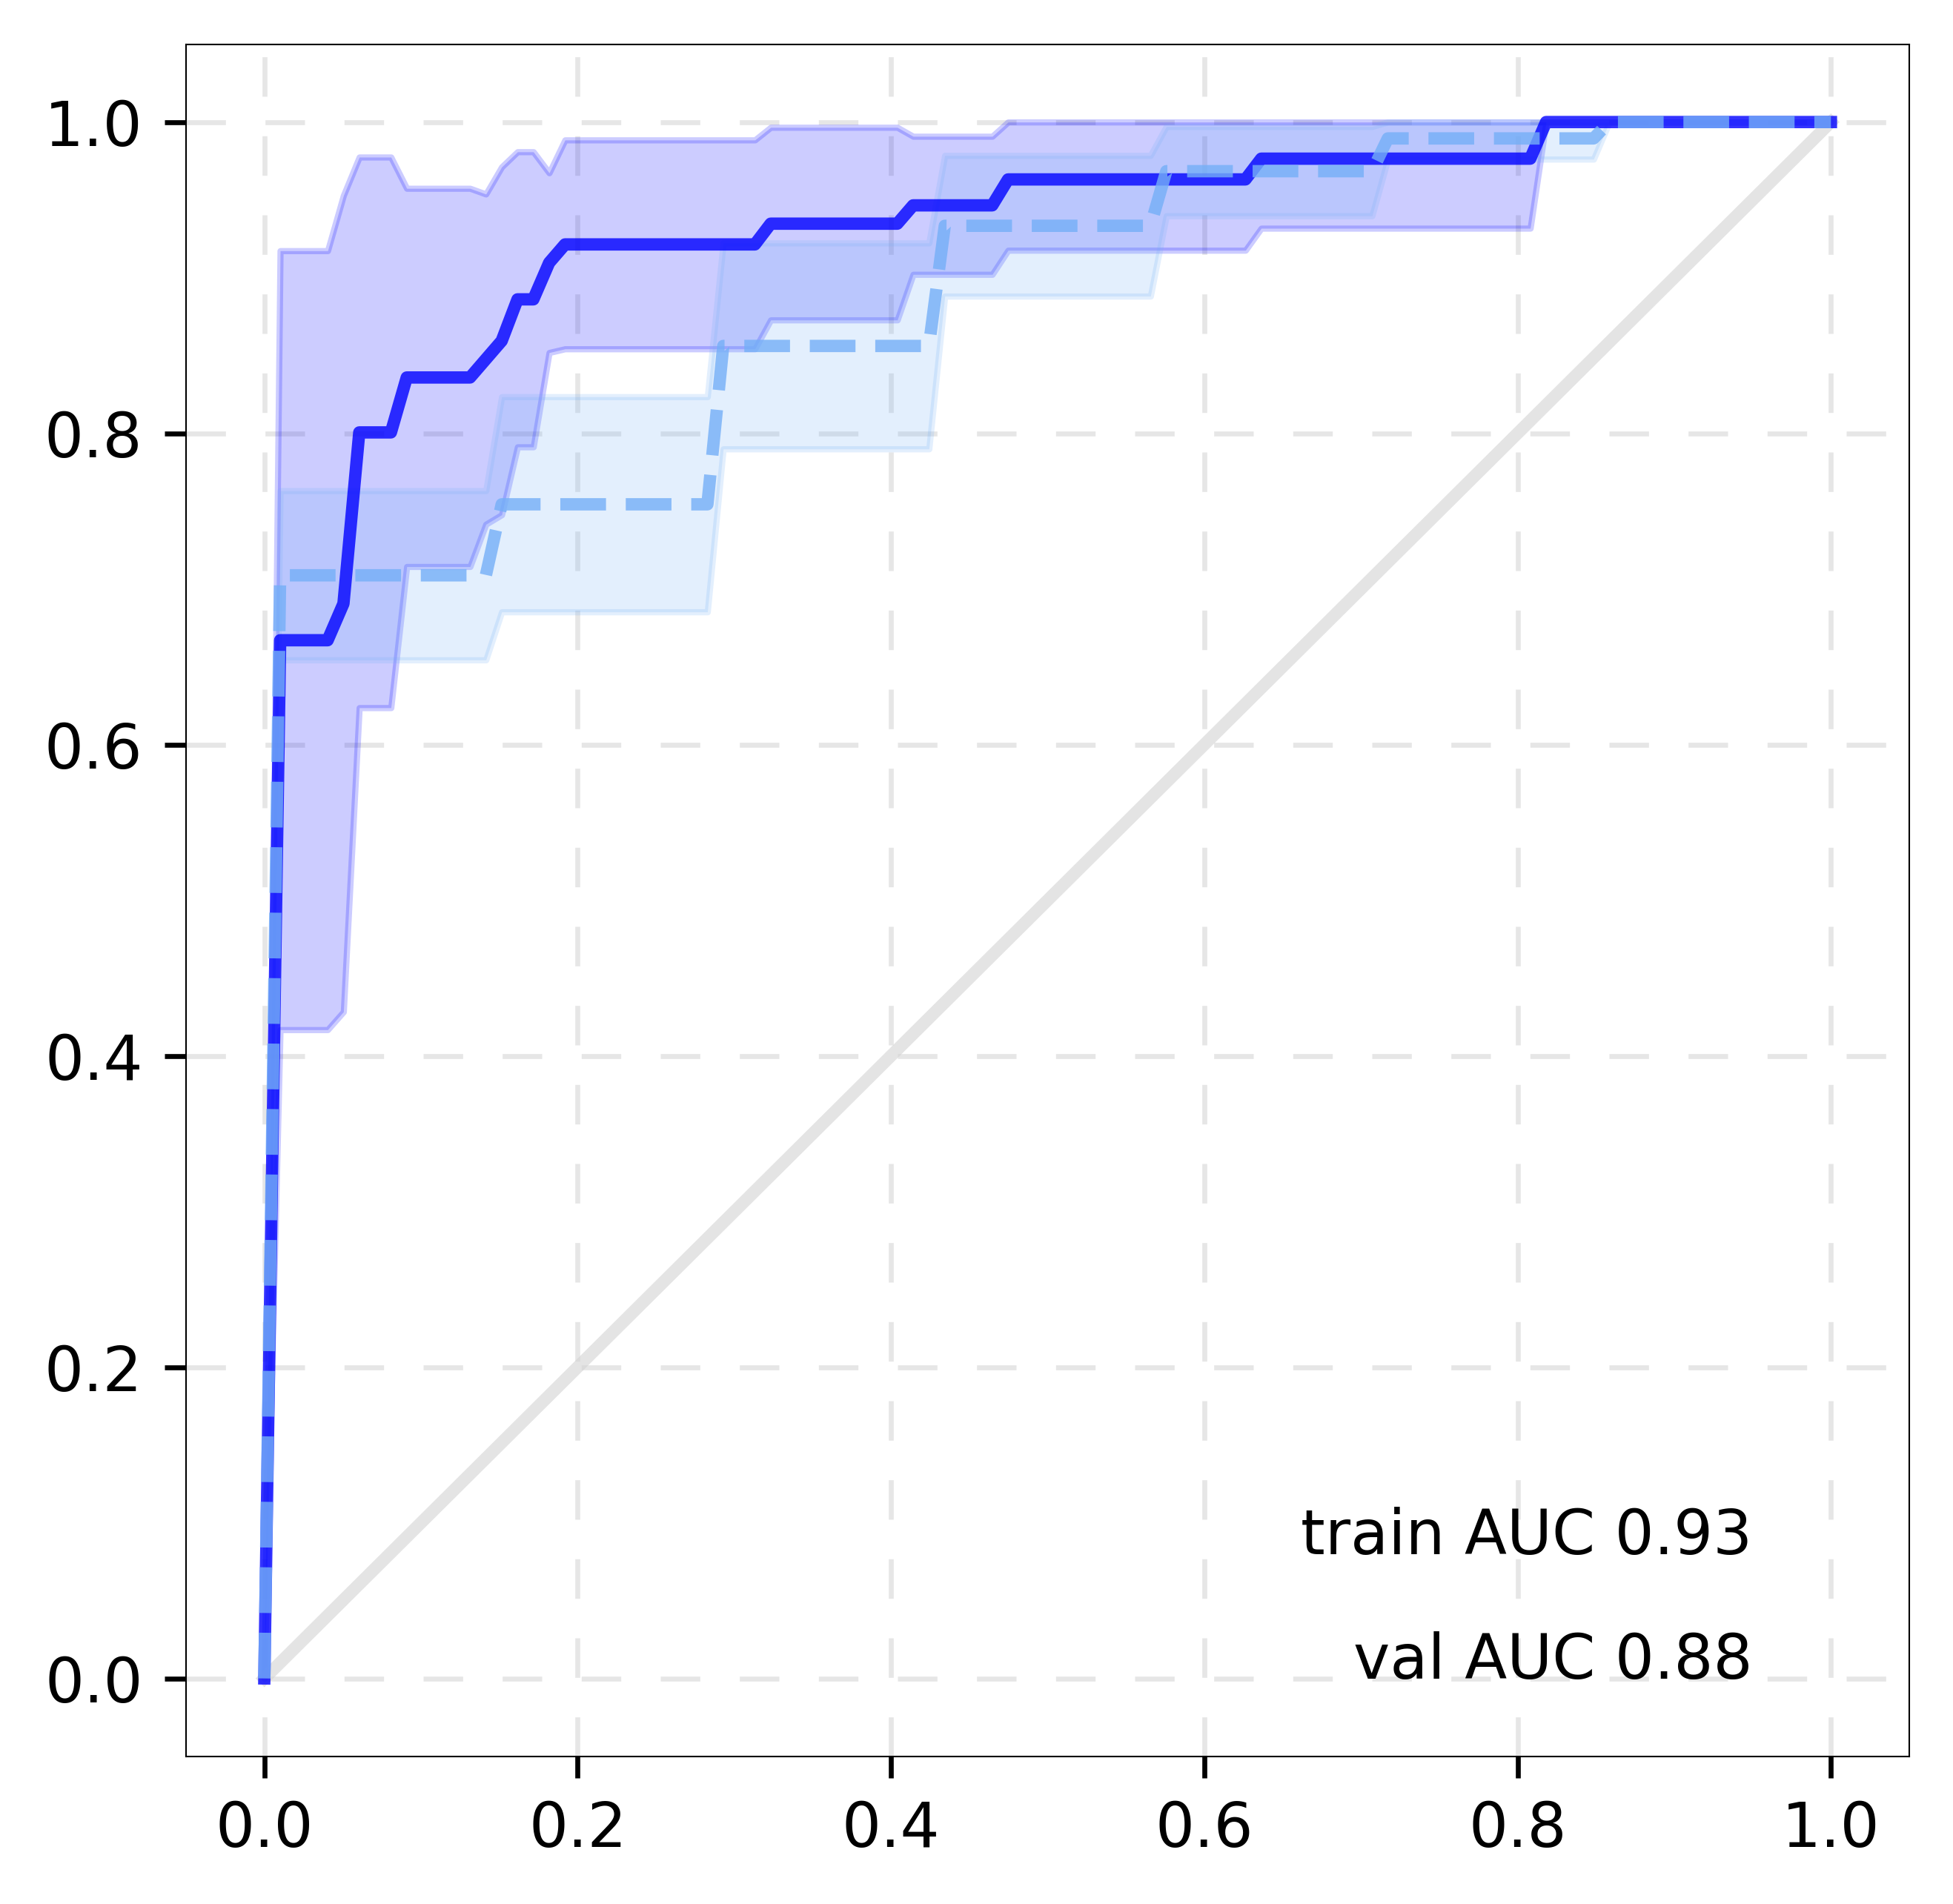

In [46]:
# all suitable metabolites
df_save = test_model(df_train_new, df_val_new, col_OE, title=all_metab+no_drift, modelname=modelname, drift=drift, hyper_param=hyper_param)
df_results = pd.concat([df_results,df_save])

Results for xg and drift for all hydrophilic metabolites(not drift corrected)
Train Sensitivity:  0.845360824742268  Specificity:  0.8194444444444444  Accuracy:  0.834319526627219  Balanced Accuracy:  0.8324026345933562
Validation Sensitivity:  0.22435897435897437  Specificity:  1.0  Accuracy:  0.621875  Balanced Accuracy:  0.6121794871794872
Joint Sensitivity:  0.46245059288537554  Specificity:  0.9449152542372881  Accuracy:  0.6952965235173824  Balanced Accuracy:  0.7036829235613318


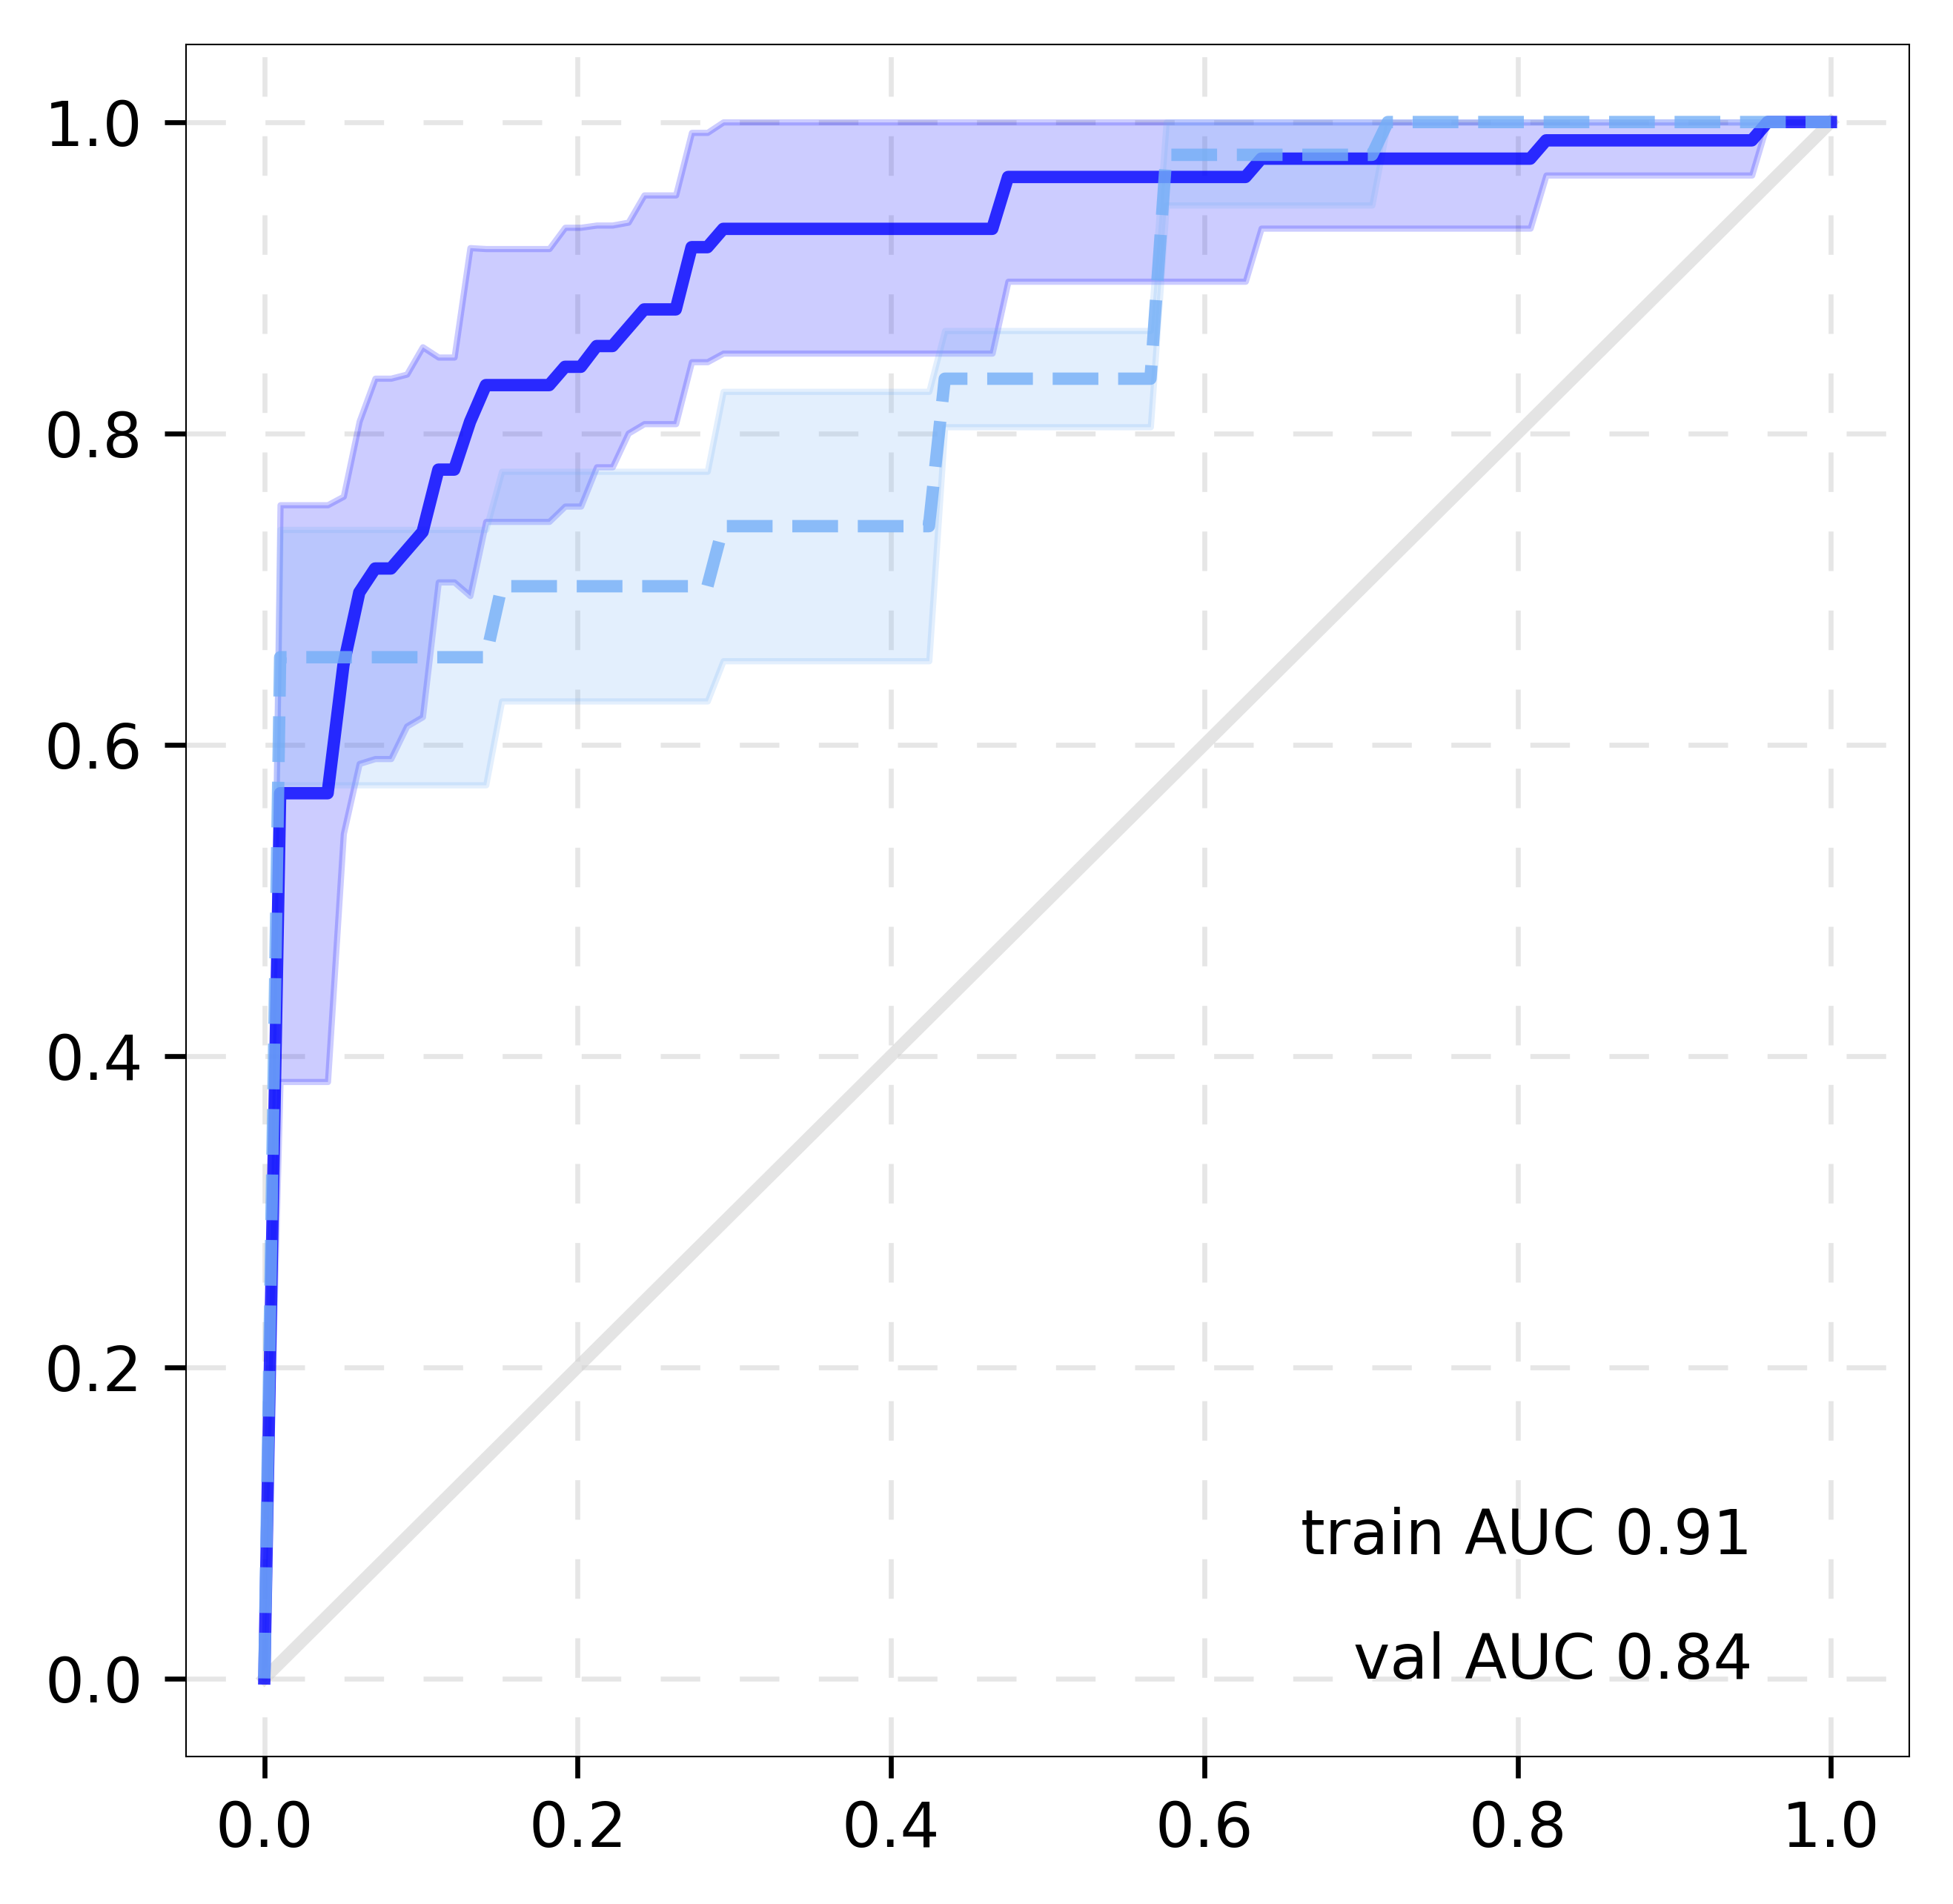

In [47]:
# all hydrophilic metabolites
df_save = test_model(df_train_new, df_val_new, col_hydrophilic_oe, title=all_hyd+no_drift, modelname=modelname, drift=drift, hyper_param=hyper_param)
df_results = pd.concat([df_results,df_save])

Results for xg and drift for all lipophilic FFAs&lipids(not drift corrected)
Train Sensitivity:  0.8571428571428571  Specificity:  0.6464646464646465  Accuracy:  0.7337278106508877  Balanced Accuracy:  0.7518037518037518
Validation Sensitivity:  0.30379746835443033  Specificity:  0.954356846473029  Accuracy:  0.79375  Balanced Accuracy:  0.6290771574137297
Joint Sensitivity:  0.5637583892617449  Specificity:  0.8647058823529411  Accuracy:  0.7730061349693251  Balanced Accuracy:  0.714232135807343


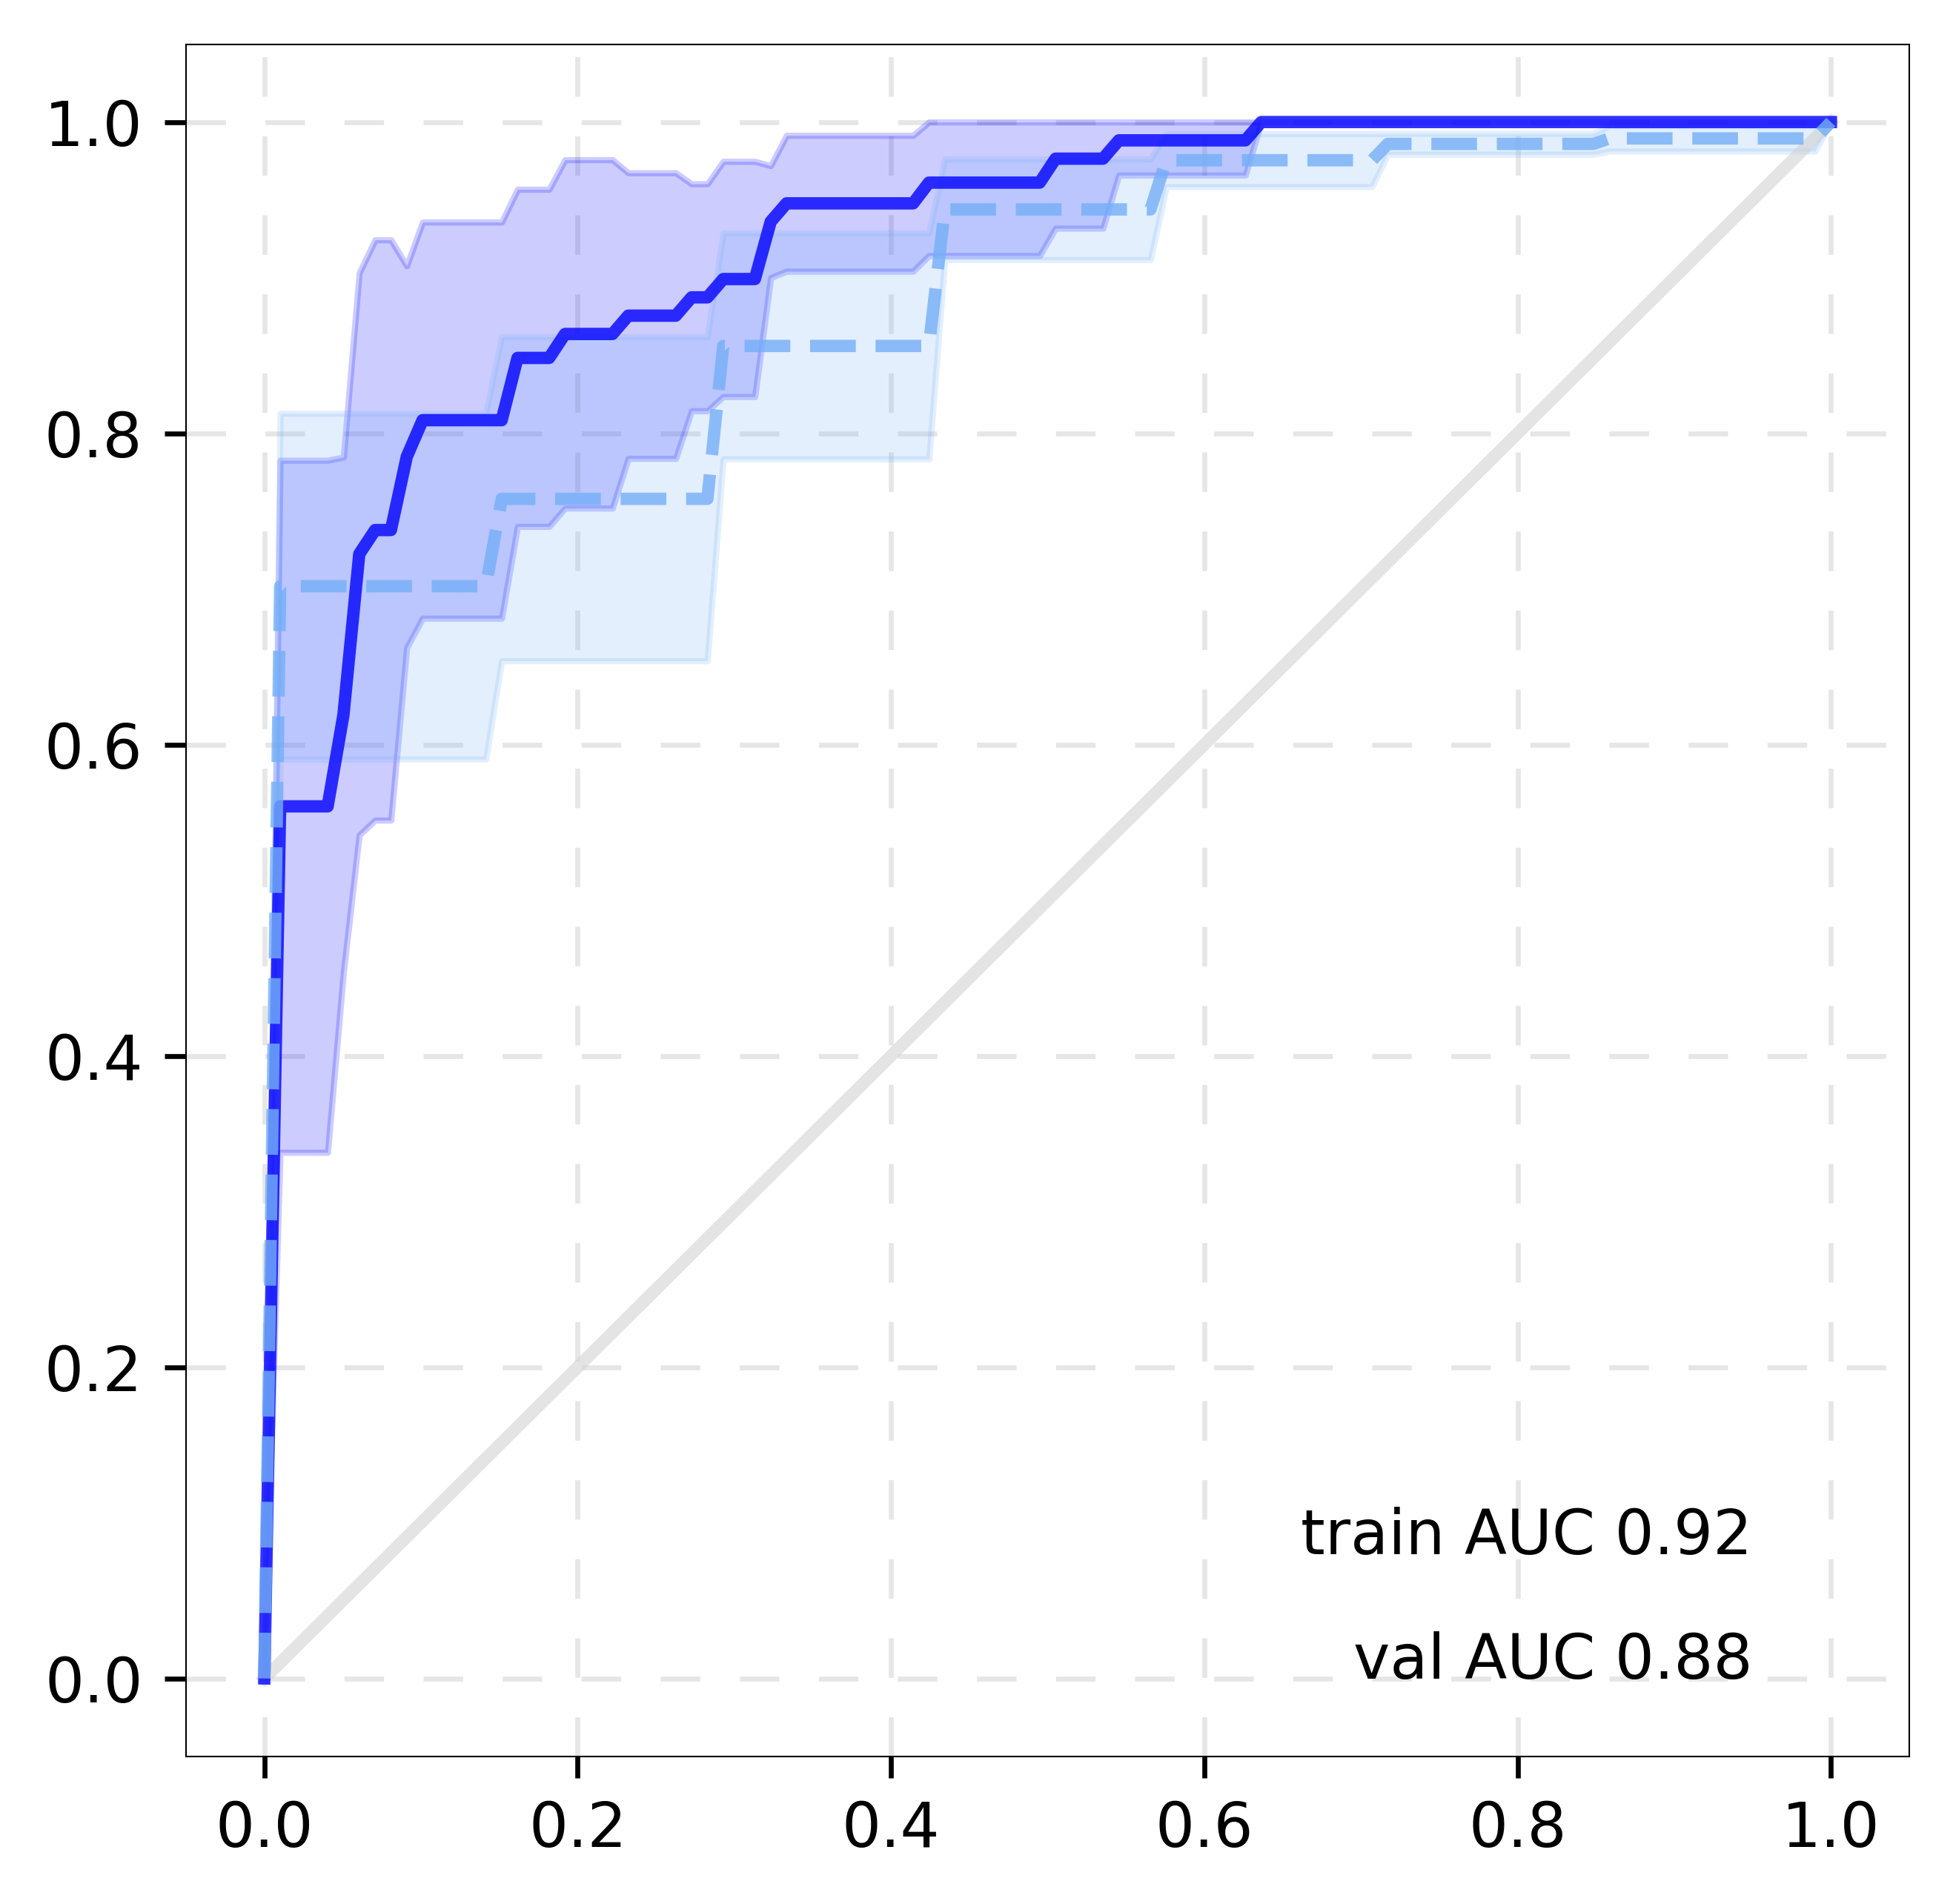

In [48]:
# all lipophilic metabolites
df_save = test_model(df_train_new, df_val_new, col_lipophilic_oe, title=all_lip+no_drift, modelname=modelname, drift=drift, hyper_param=hyper_param)
df_results = pd.concat([df_results,df_save])

### All results of the calculations

In [49]:
df_results

,test_Sensitivity,test_Specificity,test_Accuracy,test_BACC,val_Sensitivity,val_Specificity,val_Accuracy,val_BACC,joint_Sensitivity,joint_Specificity,joint_Accuracy,joint_BACC,test_AUC,val_AUC,joint_AUC
rfdrift correctionsuitable metabolites,0.941176,0.821429,0.881657,0.881303,0.220126,1.000000,0.612500,0.610063,0.471311,0.938776,0.705521,0.705043,0.950591,0.824498,0.887544
rfdrift correctionhydrophilic metabolites,0.913580,0.761364,0.834320,0.837472,0.175182,0.939891,0.612500,0.557537,0.449541,0.881919,0.689162,0.665730,0.929324,0.750824,0.840074
rfdrift correctionlipophilic FFAs&lipids,0.884211,0.851351,0.869822,0.867781,0.209581,1.000000,0.587500,0.604790,0.454198,0.951542,0.685072,0.702870,0.957625,0.930698,0.944162
rfdriftsuitable metabolites(not drift corrected),0.948718,0.769231,0.852071,0.858974,0.231481,0.952830,0.709375,0.592156,0.532258,0.897690,0.758691,0.714974,0.950156,0.838392,0.894274
rfdrifthydrophilic metabolites(not drift corrected),0.912500,0.752809,0.828402,0.832654,0.206897,0.946078,0.678125,0.576487,0.494898,0.887372,0.730061,0.691135,0.930290,0.802195,0.866242
rfdriftlipophilic FFAs&lipids(not drift corrected),0.921053,0.731183,0.816568,0.826118,0.322917,0.982143,0.784375,0.652530,0.587209,0.908517,0.795501,0.747863,0.948339,0.934672,0.941506
xgdrift correctionsuitable metabolites,0.868687,0.871429,0.869822,0.870058,0.192308,1.000000,0.540625,0.596154,0.430605,0.956731,0.654397,0.693668,0.939332,0.831207,0.885269
xgdrift correctionhydrophilic metabolites,0.846939,0.830986,0.840237,0.838962,0.198864,1.000000,0.559375,0.599432,0.430657,0.944186,0.656442,0.687421,0.912330,0.750328,0.831329
xgdrift correctionlipophilic FFAs&lipids,0.840000,0.840580,0.840237,0.840290,0.180412,1.000000,0.503125,0.590206,0.404762,0.943590,0.619632,0.674176,0.942021,0.878345,0.910183
xgdriftsuitable metabolites(not drift corrected),0.934211,0.741935,0.828402,0.838073,0.271845,0.967742,0.743750,0.619793,0.553073,0.900000,0.773006,0.726536,0.928126,0.883307,0.905717


In [51]:
df_results.to_excel('ML_statistics.xlsx')